# Libary and color settings

In [1]:
# Peter van Galen, 211111
# Test different parameters to select informative variants from the clonal hematopoiesis sample.


#~~~~~~~~~~~~~~~~~~~~~#
#### Prerequisites ####
#~~~~~~~~~~~~~~~~~~~~~#

options(scipen = 999)

library(tidyverse)
library(SummarizedExperiment)
library(Seurat)
library(Matrix)
library(readxl)
library(ComplexHeatmap)
library(circlize) # For heatmap colors
#library(magick) # For heatmap rasterization
library(mclust) # For adjusted rand index
library("ggpubr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4      ✔ purrr   0.3.5 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, col

In [120]:
#color settings
col_pal = c("#264653","#2a9d8f","#e9c46a","#7cb518","#e76f51", 
            "#606c38","#283618","#fefae0","#dda15e","#bc6c25",
            "#f94144","#f3722c","#f8961e","#f9844a","#f9c74f",
            "#90be6d","#43aa8b","#4d908e","#577590","#277da1",
             "#e4c1f9", "#a9def9","#d0f4de", "#1b263b","#5f0f40",
            "#415a77", "#778da9", "#e0e1dd", "#3d348b","#9a031e",
            "#ffdac6", "#e36414", "#0f4c5c", "#33a1fd", "#7678ed",
           "#c0d6df", "#e9f5db")

lineage_pal = c("#ffd449", "#6b9080", "#f7b267", "#62b6cb", "#ff8fab", "#bc6c25", "#457b9d", "#4f772d")

In [3]:
type_list = c("Advanced Mesoderm", "Axial Mesoderm", "Non-Neural Ectoderm", "Emergent Mesoderm", "Endoderm", "Epiblast", "Erythroblasts","Hemogenic Endothelial Progenitors", 
            "Nascent Mesoderm", "Primitive Streak", "ExE Mesoderm")
pal1 = color_list=c('#4E9C6D',"#84584E",'#58BDCC','#B6BD6E','#EF8635','#3C76AF','#C53933', '#9D48F3','#D57DBF','#B3C6E5','#f4aeae')
ann_col=list(pal1)
names(ann_col)="CellType"
names(ann_col$CellType) = type_list


# New data

In [287]:
out_dir = "/syn1/wangxin/work/SS2/embryo"
sample_name = "embryo"
df = read.csv("/data/wangxin/work/MT_bm/SS2/embryo/tzj/outs/embryo_mtSNV_final.csv", row.names = 1, check.names = F)
meta = read.csv("/data/wangxin/work/MT_bm/SS2/embryo/embryo_d16_meta.csv", row.names=1)
#ct1 = c('Naive_B', 'Memory_B', 'CD4T_Naive', 'CD4T_Memory', 'CD8T_Naive', 'CD8T_Memory', 'NK', 
#                                        'CD14_Monocytes','CD16_Monocytes', 'cDC', 'pDC', 'Basophils')
#dis_color_vec = read.csv("/data/wangxin/ref/discrete_color.csv")$color
type_list = c("Advanced Mesoderm", "Axial Mesoderm", "Non-Neural Ectoderm", "Emergent Mesoderm", "Endoderm", "Epiblast", "Erythroblasts","Hemogenic Endothelial Progenitors", 
            "Nascent Mesoderm", "Primitive Streak", "ExE Mesoderm")
pal1 = color_list=c('#4E9C6D',"#84584E",'#58BDCC','#B6BD6E','#EF8635','#3C76AF','#C53933', '#9D48F3','#D57DBF','#B3C6E5','#f4aeae')
ann_col=list(pal1)
names(ann_col)="CellType"
names(ann_col$CellType) = type_list
common_cells = intersect(rownames(meta), colnames(df))
df = df[,common_cells]
af.dm = as.matrix(df*100)
af.dm = af.dm[,colnames(af.dm) %in% rownames(meta)] #keep cells with annotation
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
#vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time

Time difference of 1.008476 secs

In [288]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Test different variant selection thresholds #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Specify variant selection thresholds to test. voi = variant of interest
conditions.tib <- tibble(min_clone_size = rep(seq(10, 100, by = 10), 4),
                         min_vaf = rep(c( "n5", "n10","n20", "n50"), each = 10),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm))
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {

    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code
        
        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}
conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls
conditions.tib

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n5,"736C>T, ....",161,ERR46752....,1167,0.9316770
20,n5,"890C>T, ....",21,ERR46752....,767,0.8095238
30,n5,"2617A>G,....",10,ERR46752....,534,0.8000000
40,n5,"2617A>G,....",6,ERR46752....,312,0.6666667
50,n5,"4718A>G,....",3,ERR46752....,173,0.6666667
60,n5,13710A>T,1,ERR46752....,63,0.0000000
70,n5,NA,0,NA,NA,NA
80,n5,NA,0,NA,NA,NA
90,n5,NA,0,NA,NA,NA


In [289]:
plot_df = conditions.tib %>%
    mutate(min_vaf = str_c(gsub("n", "", min_vaf), "%")) %>%
    mutate(min_vaf = factor(min_vaf, levels = c( "5%", "10%", "20%", "50%")))

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


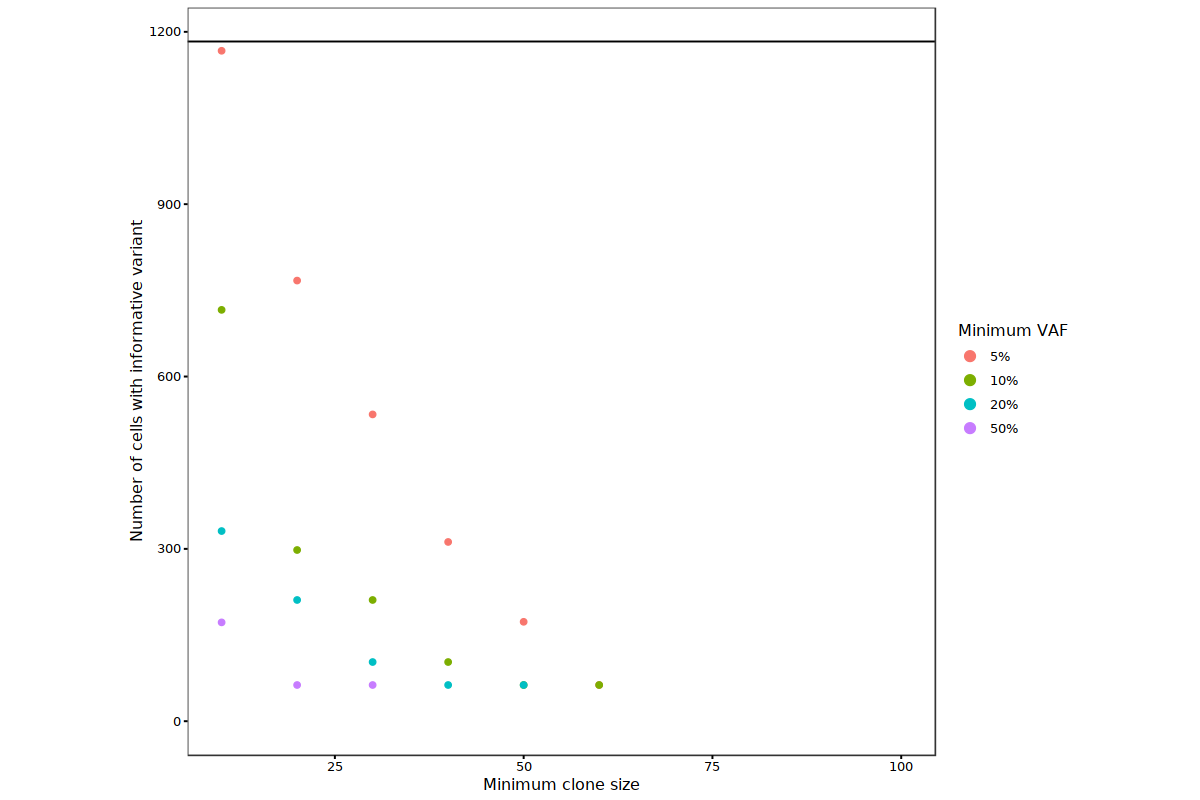

In [290]:
ggplot(plot_df, aes(x = min_clone_size, y = n_cells, color = min_vaf)) + #, size = n_vois
    geom_hline(yintercept = ncol(af.dm)) +
    geom_point() +
    coord_cartesian(ylim = c(0, ncol(af.dm))) +
    ylab("Number of cells with informative variant") +
    xlab("Minimum clone size") +
    theme_bw() +
    guides(color = guide_legend(override.aes = list(size = 3),
                                title = "Minimum VAF")) +
    theme(aspect.ratio = 1,
          panel.grid = element_blank(),
          axis.ticks = element_line(color = "black"),
          axis.text = element_text(color = "black"))

In [291]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(10,20), min_vaf %in% c("n10","n20","n50"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n10,"972G>A, ....",19,ERR46752....,716,0.7894737
20,n10,"2617A>G,....",6,ERR46752....,298,0.8333333
10,n20,"972G>A, ....",8,ERR46752....,331,0.8750000
20,n20,"2617A>G,....",4,ERR46752....,211,0.7500000
10,n50,"2617A>G,....",4,ERR46752....,172,0.7500000
20,n50,13710A>T,1,ERR46752....,63,0.0000000


## VAF 20

In [292]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=3
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


In [293]:
# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



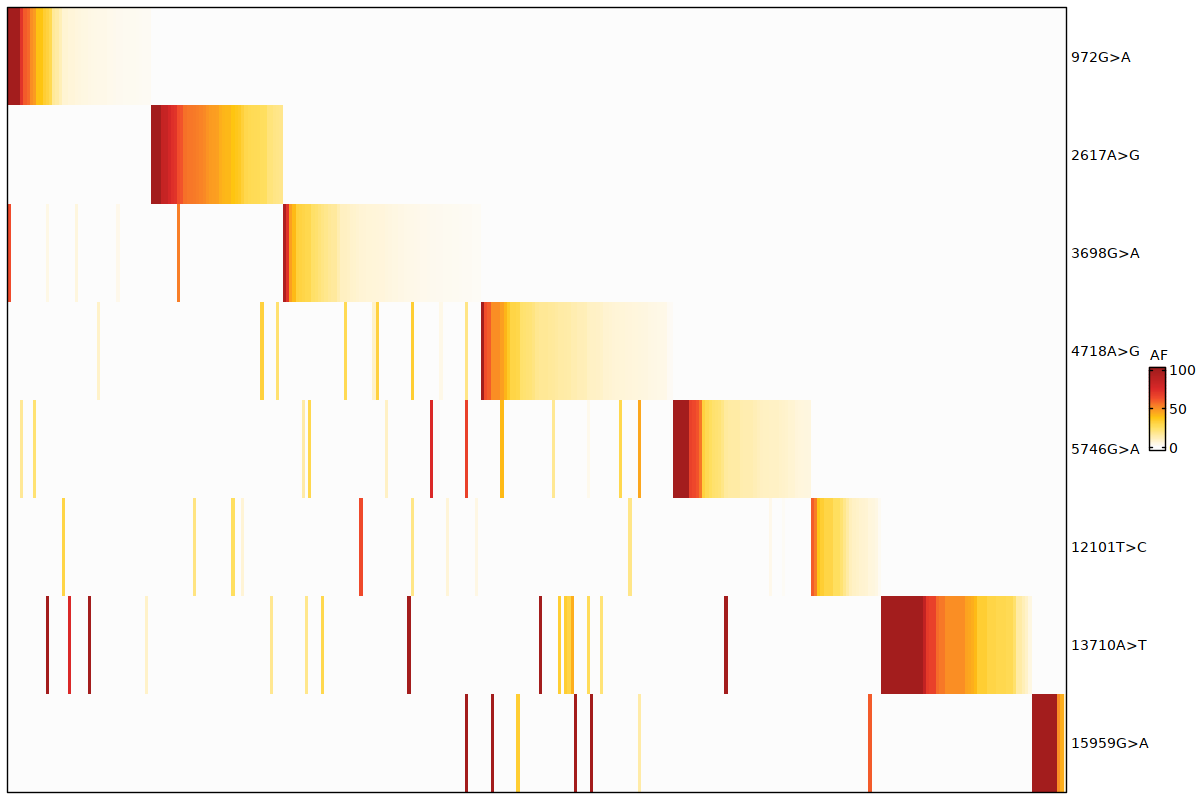

In [294]:
#options(repr.plot.width=16, repr.plot.height=12)
Heatmap(plot_order.mat,
              col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                               c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
              show_row_names = ifelse(nrow(plot_order.mat) < 100, T, F),
              show_column_names = F,
              cluster_columns = F,
              cluster_rows = F,
              row_names_gp = gpar(fontsize = 10),
              name = "AF",
              heatmap_legend_param = list(border = "#000000", grid_height = unit(10, "mm")),
              #top_annotation = ha,
              border = T,
              #width = unit(250, "mm"),
              #height = unit(120, "mm"),
              use_raster = T,
              raster_quality = 5)

In [295]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

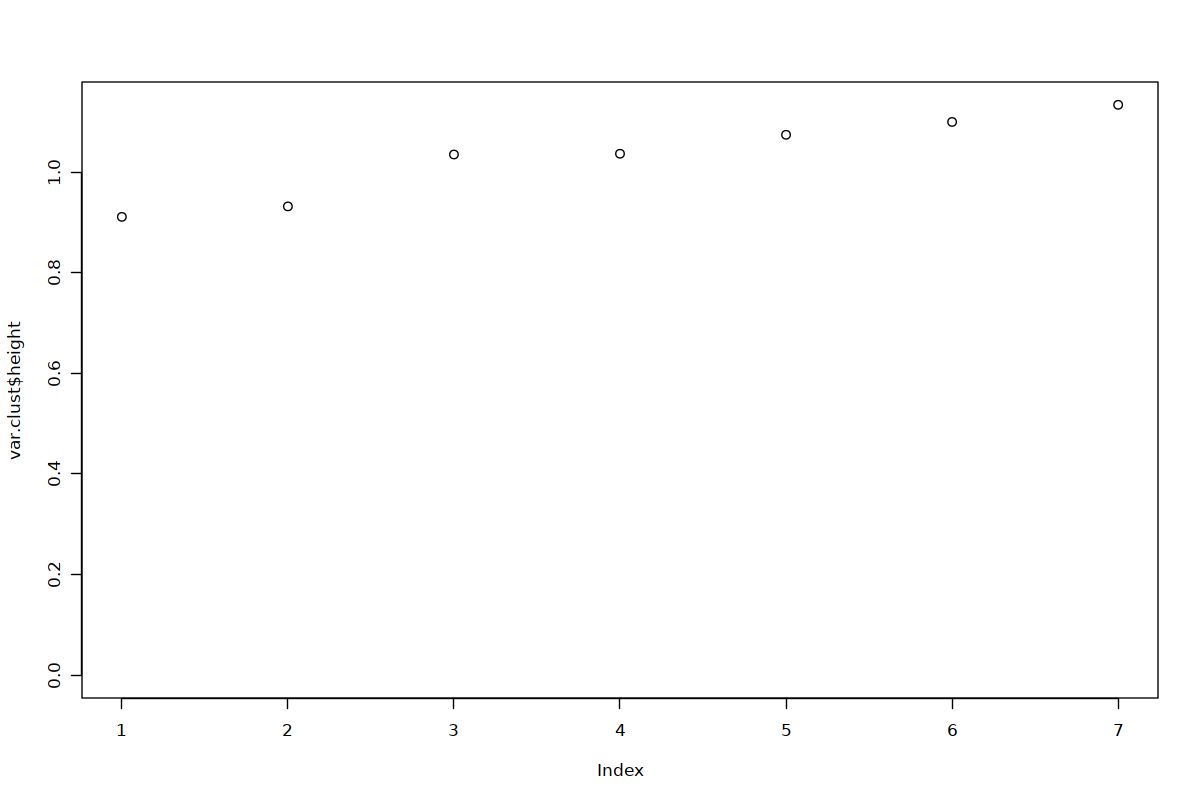

In [296]:
plot(var.clust$height, ylim = c(0, max(var.clust$height)))

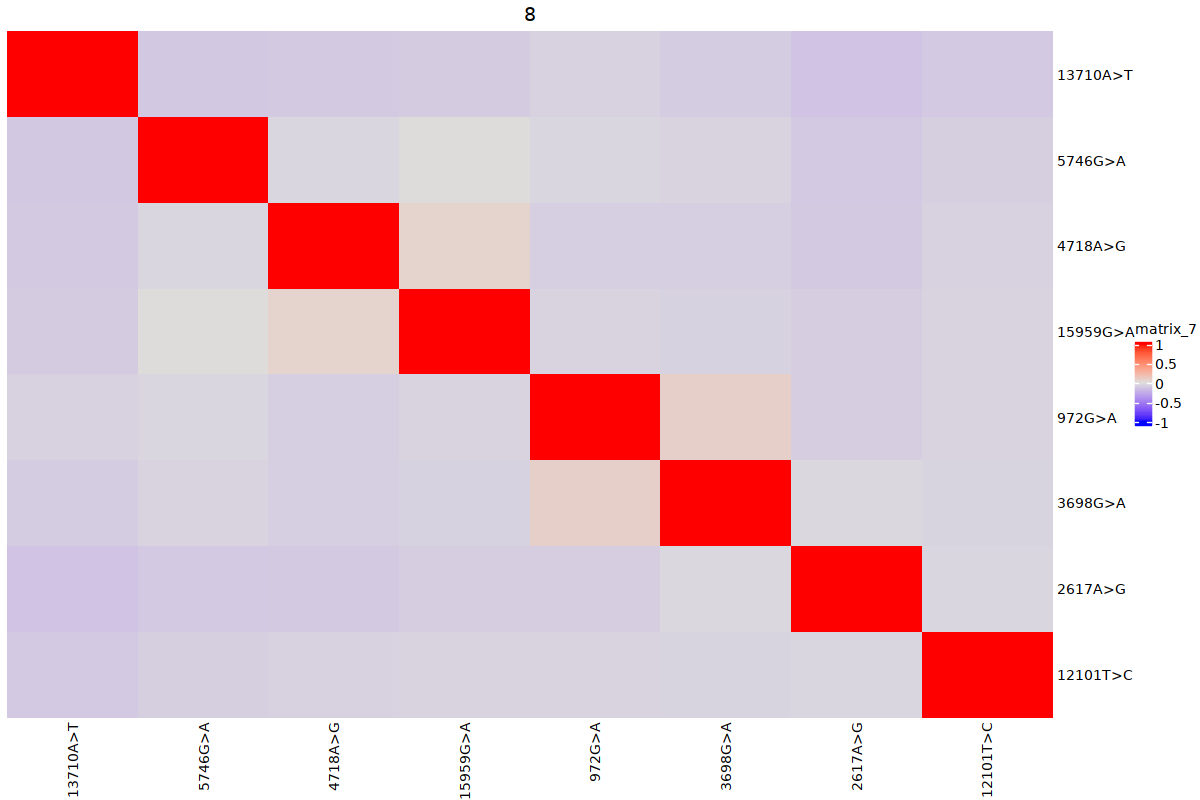

In [297]:

ngroups=length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



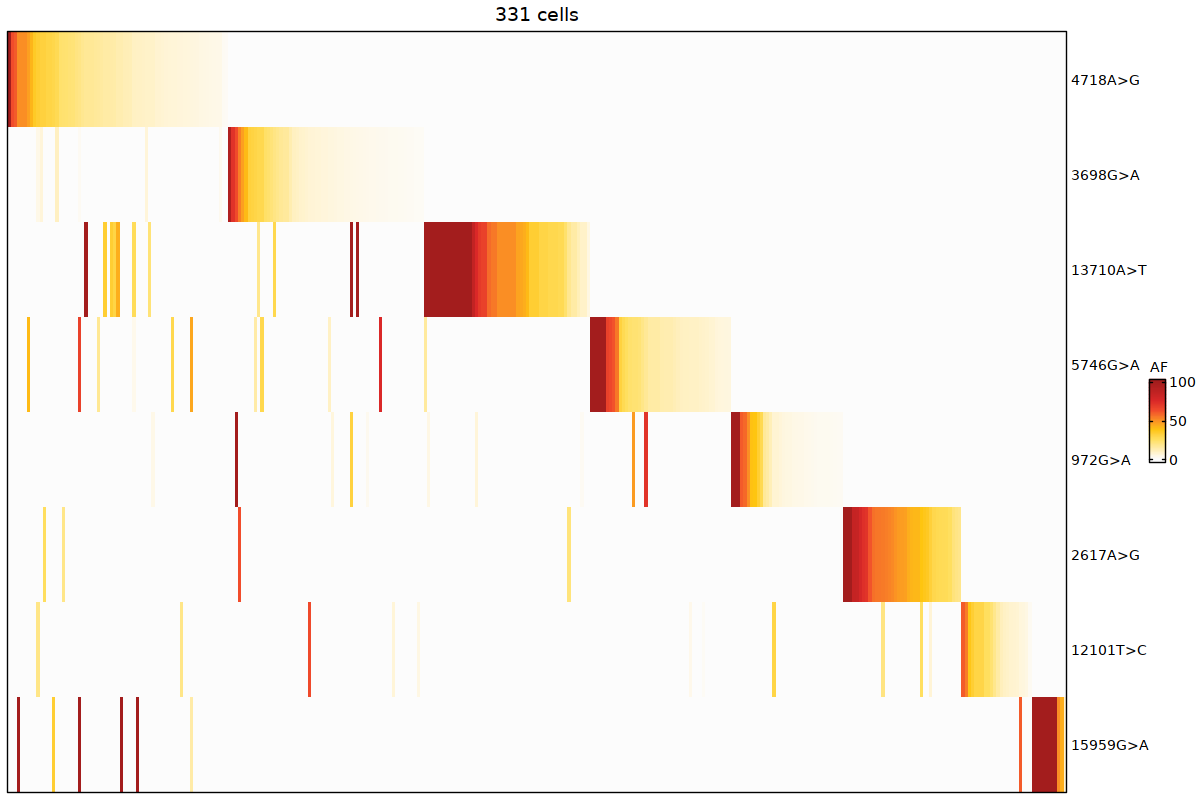

In [298]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}
Heatmap(plot_order.mat, column_title = paste0(ncol(plot_order.mat)," cells"), 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

In [299]:

tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))

CIV_file_name = paste0(out_dir,"/CIV/CIV_clones_", sample_name,"_VAF20.csv")
write.csv(clone_info_df, file = CIV_file_name, quote = F, row.names = F)
message("Clone info has been saved to: ", CIV_file_name)
new_plot_mat = new2
                                   

Clone info has been saved to: /syn1/wangxin/work/SS2/embryo/CIV/CIV_clones_embryo_VAF20.csv



In [300]:

new_plot_mat1 = new_plot_mat/100 
all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mv1)
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        mv1 = mean(tmp_vaf_ls)/(1+var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mv1)
}

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, "_VAF20.csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean, variance and MV1 info have been saved to: ", meanvar_file_name)


Mean, variance and MV1 info have been saved to: /syn1/wangxin/work/SS2/embryo/CIV/meanvar_CIV_embryo_VAF20.csv



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

CIV heatmaps have been saved to: /syn1/wangxin/work/SS2/embryo/plots/embryo_CIV_heatmap_vaf20.pdf



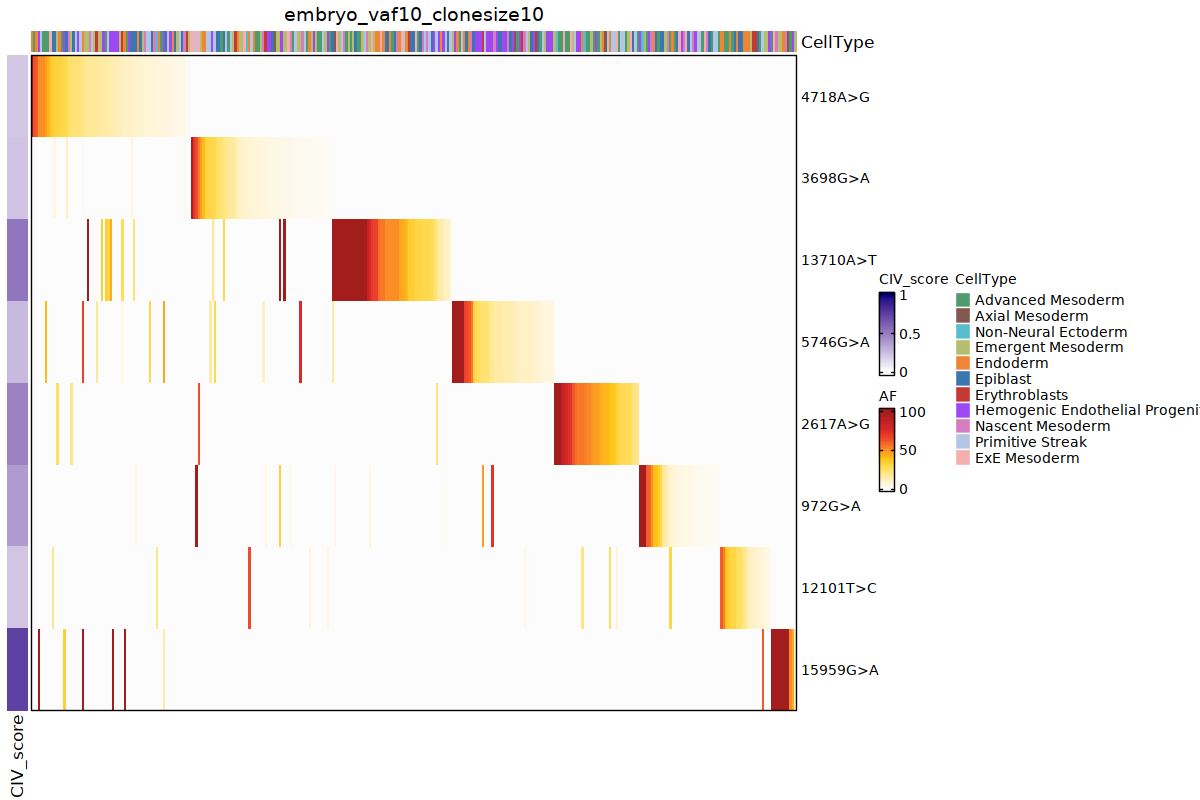

In [286]:
options(repr.plot.width=12, repr.plot.height=8)
#annotation_colors <- scale_fill_viridis_c(option = "plasma", begin = 0, end = 1.0)
meta.tib = as_tibble(meta[rownames(meta) %in% colnames(af.dm),])
meta.tib$cell = rownames(meta[rownames(meta) %in% colnames(af.dm),])
annot.tib = tibble(cell = colnames(new_plot_mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = type_list)
ha <- HeatmapAnnotation(df = ct_plot_df, col = ann_col)

col_pal = colorRamp2(c(0, 1), c( "white", "navyblue"))
row_annot <- rowAnnotation(
  df = data.frame(CIV_score = sub_MV1_ls),
  col = list(CIV_score = col_pal), annotation_legend_param = list(border = "#000000"))

#row_annot = rowAnnotation(CIVS = sub_MV1_ls, col = colorRamp2(c(0, 1), c("green",  "red")))
htmap_p = Heatmap(new_plot_mat, column_title = "embryo_vaf10_clonesize10", 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
                left_annotation = row_annot,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

htmap_p

heatmap_name = paste0(out_dir,"/plots/",sample_name,"_CIV_heatmap_vaf20.pdf")
pdf(heatmap_name, height = 2.645, width = 5)
htmap_p
dev.off()
message(paste0("CIV heatmaps have been saved to: ", heatmap_name))

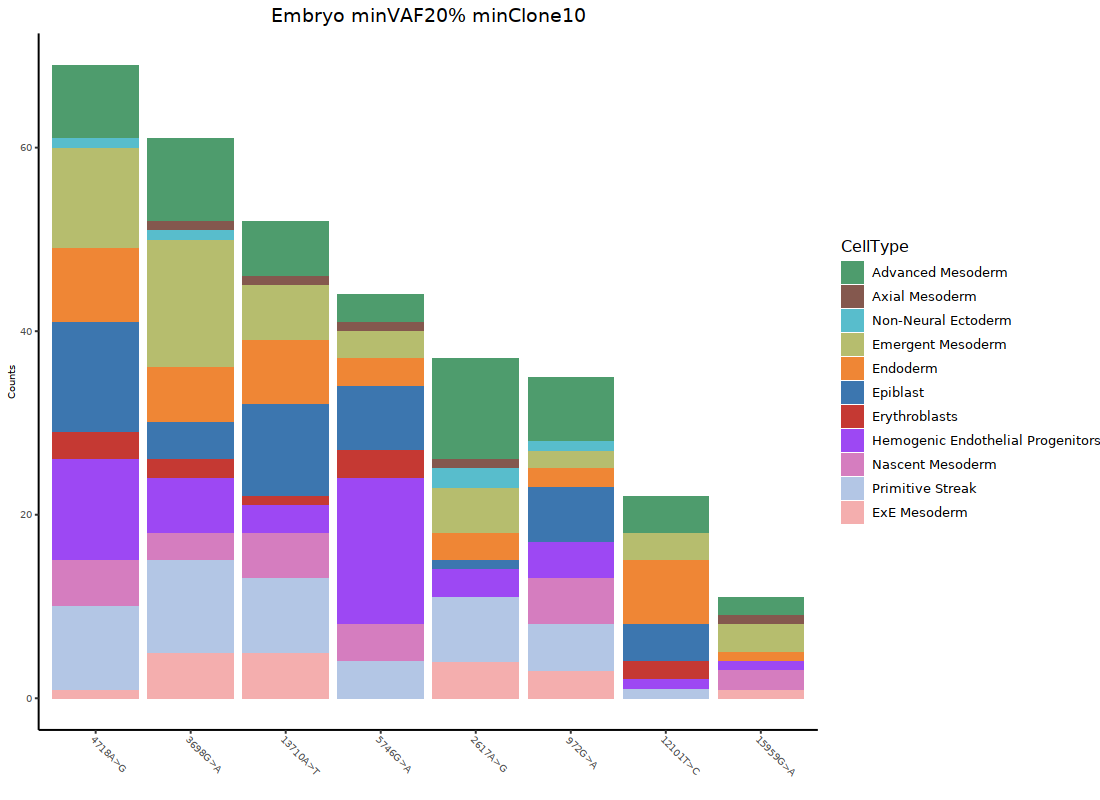

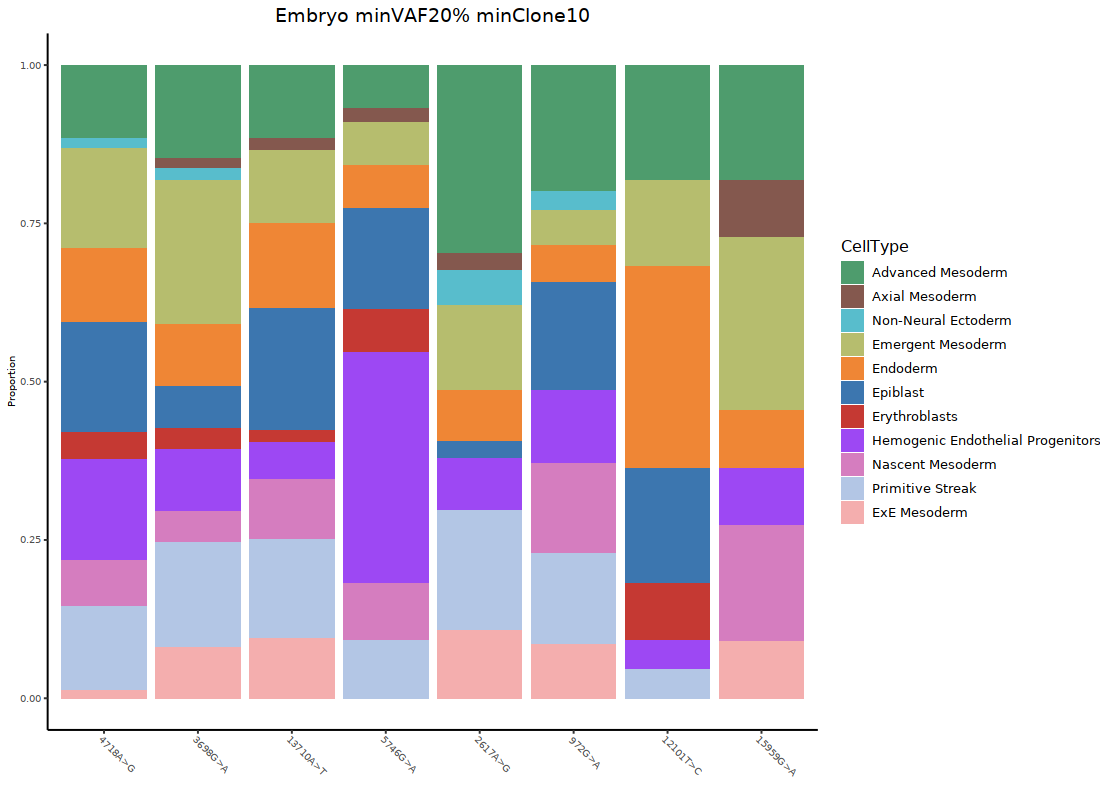

In [458]:
ct_df = data.frame(matrix(nrow=0, ncol=4)) 
for (i in rownames(plot_order.mat)) {
    tmp_ct_df = as.data.frame(table(meta[clone_info_df$Cell[clone_info_df$Clone == i],"CellType"]))
    tmp_ct_df$Proportion = tmp_ct_df[,2]/sum(tmp_ct_df[,2])
    tmp_ct_df$Clone = i
    ct_df = rbind(ct_df, tmp_ct_df)
}

colnames(ct_df) = c("CellType", "Counts", "Proportion", "Clone")
#ct1 = c('Naive_B', 'Memory_B', 'CD4T_Naive', 'CD4T_Memory', 'CD8T_Naive', 'CD8T_Memory', 'NK', 
#                                        'CD14_Monocytes','CD16_Monocytes', 'cDC', 'pDC', 'Basophils')
ct_df$CellType = factor(ct_df$CellType, levels = type_list)
ct_df$Clone = factor(ct_df$Clone, levels = rownames(new_plot_mat) )

#pal1 = c('#D51F26','#272E6A','#89288F','#F47D2B','#FEE500','#8A9FD1','#C06CAB','#D8A767','#90D5E4','#89C75F','#F37B7D','#9983BD')
pal1 = ann_col$CellType

p2 = ggplot(ct_df, aes(x=Clone, y=Counts, fill=CellType)) + geom_bar(stat = "identity") + labs(title = "Embryo minVAF20% minClone10") + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 315, hjust = 0.1, vjust = 0.5)) + scale_fill_manual(values=pal1) + xlab("")
p2
p3 = ggplot(ct_df, aes(x=Clone, y=Proportion, fill=CellType)) + geom_bar(stat = "identity") + labs(title = "Embryo minVAF20% minClone10") + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 7), axis.title = element_text(size=7),
        axis.text.x = element_text(angle = 315, hjust = 0.1, vjust = 0.5)) + scale_fill_manual(values=pal1) + xlab("")
p3

In [459]:
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_celltype_comp_early_vaf20.pdf", p3, height = 2.1, width = 5)

In [304]:
af.dm["15959G>A",clone_info_df[clone_info_df$Clone == "15959G>A", "Cell"]]

ERR4675394 ERR4675425 ERR4675742 ERR4676030 ERR4676036 ERR4676279 ERR4676458 
100.000000 100.000000 100.000000 100.000000 100.000000 100.000000 100.000000 
ERR4676470 ERR4675692 ERR4675556 ERR4675458 
100.000000  50.000000  42.857143   6.666667

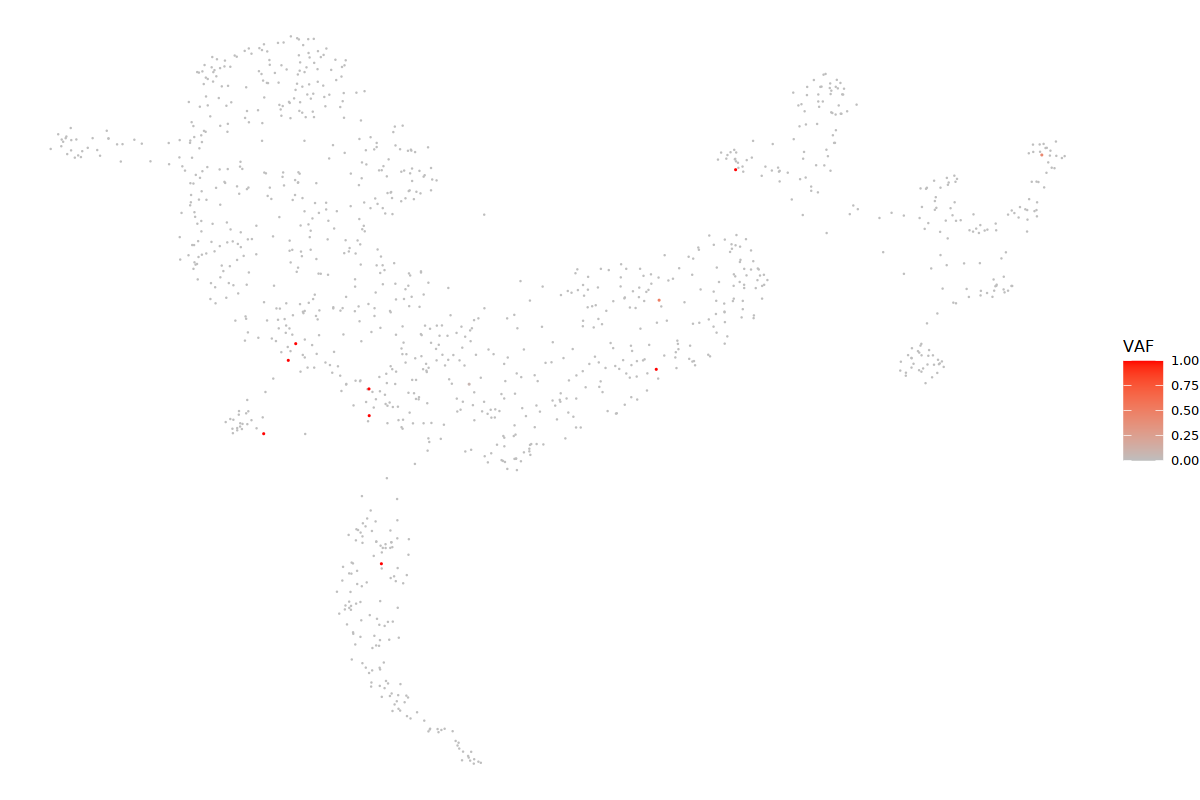

In [323]:
meta_df = read.csv("/data/wangxin/work/MT_bm/SS2/embryo/embryo_d16_meta.csv", check.names = F, row.names=1, header=T)
meta_df$VAF = 0
meta_df$Size = 0.5
meta_df[clone_info_df[clone_info_df$Clone == "15959G>A", "Cell"], "VAF"] = af.dm["15959G>A",clone_info_df[clone_info_df$Clone == "15959G>A", "Cell"]]/100
meta_df[clone_info_df[clone_info_df$Clone == "15959G>A", "Cell"], "Size"] = 0.7
meta_df = meta_df[order(meta_df$VAF),]
p4 = ggplot(meta_df, aes(x=UMAP1, y=UMAP2, color = VAF)) + geom_point(stroke = 0,  size = meta_df$Size) + theme_void() + scale_color_gradient(low = "gray", high = "red") + 
    guides(colour = guide_legend(override.aes = list(size=2))) + guides(color = guide_colorbar(barwidth = 2, barheight = 5)) 
p4
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP_legend_VAF20_15959.pdf", p4, height = 2, width = 3)

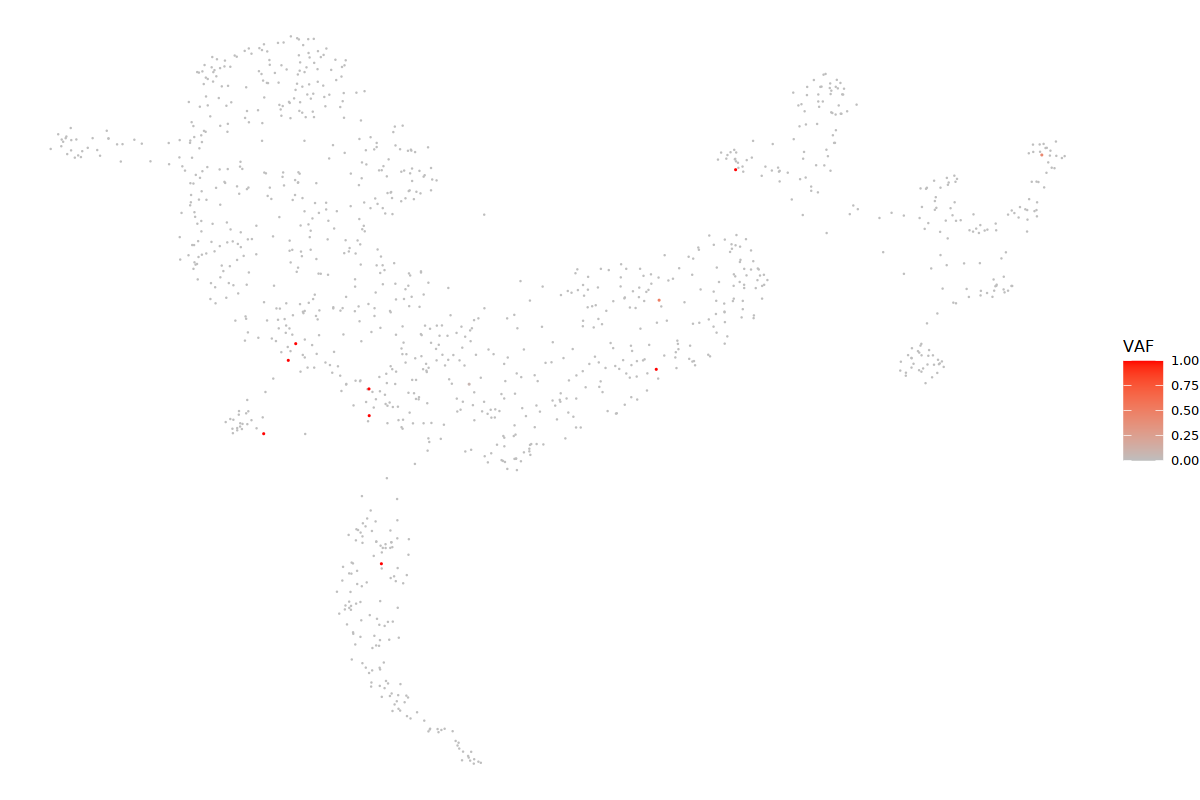

In [321]:
meta_df$Size <- 0.5

# Update VAF and Size for specific cells related to "15959G>A" clone
cell_indices <- clone_info_df[clone_info_df$Clone == "15959G>A", "Cell"]
meta_df[cell_indices, "VAF"] <- af.dm["15959G>A", cell_indices] / 100
meta_df[cell_indices, "Size"] <- ifelse(meta_df[cell_indices, "Size"] != 0.7, 0.7, 0.5)

# Order the dataframe based on VAF
meta_df <- meta_df[order(meta_df$VAF), ]

# Plotting
ggplot(meta_df, aes(x = UMAP1, y = UMAP2, color = VAF)) +
  geom_point(stroke = 0, size = meta_df$Size) +  # Set stroke to 0 for better visualization
  scale_color_gradient(low = "gray", high = "red") +
  guides(color = guide_colorbar(barwidth = 2, barheight = 5)) +
  theme_void()

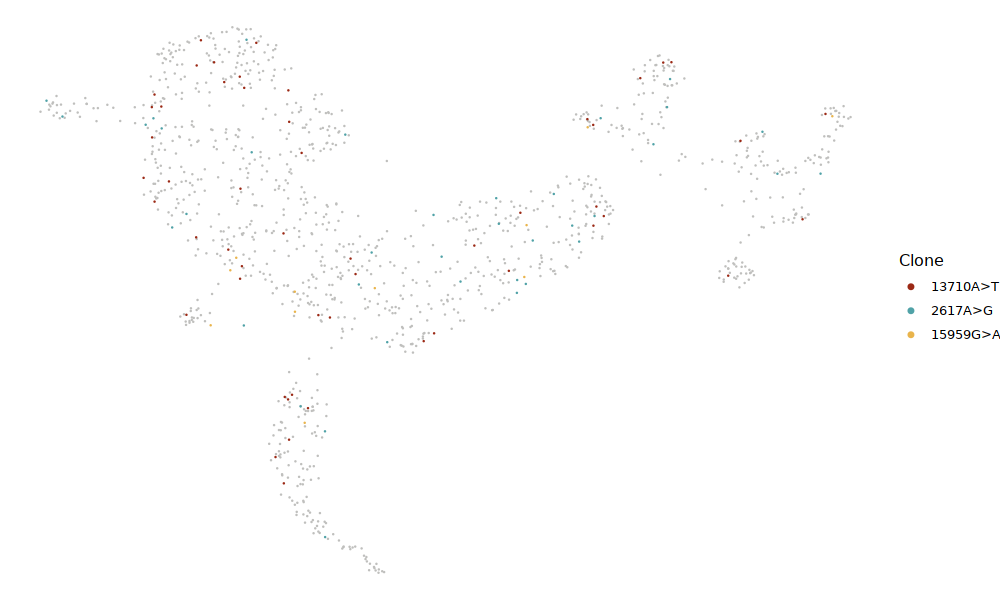

In [475]:
options(repr.plot.width=10, repr.plot.height=6)
new_pal = c("#e9b44c", "#9b2915", "#50a2a7", "#BFBFBD")
names(new_pal) = c(plot_CIV, "Other")
p4 = ggplot(meta_df, aes(x=UMAP1, y=UMAP2, color = Clone)) + geom_point(size=0.5, stroke = 0) + theme_void() + scale_color_manual(values = new_pal, breaks = CIV) + 
    guides(colour = guide_legend(override.aes = list(size=2)))
p4

ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP_legend_VAF20.pdf", p4, height = 2, width = 3)

## VAF 50

In [392]:

conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
10,n10,"972G>A, ....",19,ERR46752....,716,0.7894737
20,n10,"2617A>G,....",6,ERR46752....,298,0.8333333
10,n50,"2617A>G,....",4,ERR46752....,172,0.7500000
20,n50,13710A>T,1,ERR46752....,63,0.0000000


In [393]:
# 1. Select variants present in at least 5 cells with a VAF of >10%
# 2. Select variants present in at least 10 cells with a VAF of >10%
# 3. Select variants present in at least 5 cells with a VAF of >50%
# 4. Select variants present in at least 10 cells with a VAF of >50%
a=3
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



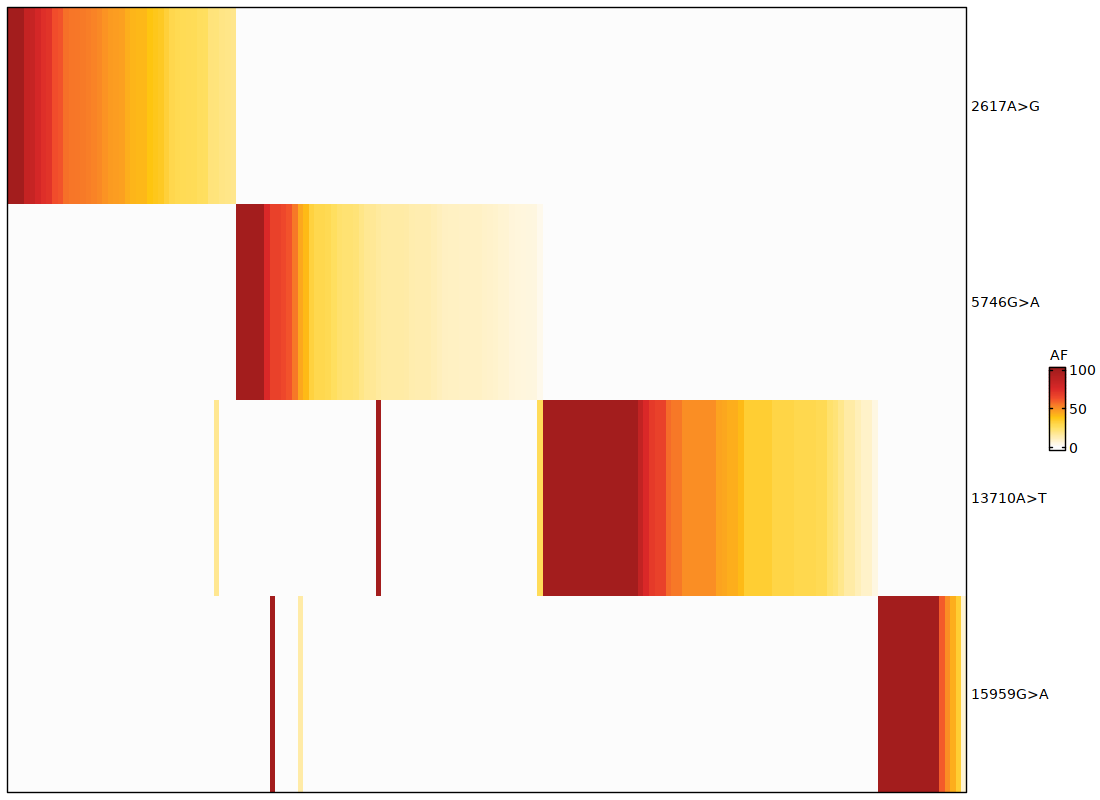

In [394]:
#options(repr.plot.width=16, repr.plot.height=12)
Heatmap(plot_order.mat,
              col = colorRamp2(seq(0, 100, length.out = 9),
                               c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
              show_row_names = ifelse(nrow(plot_order.mat) < 100, T, F),
              show_column_names = F,
              cluster_columns = F,
              cluster_rows = F,
              row_names_gp = gpar(fontsize = 10),
              name = "AF",
              heatmap_legend_param = list(border = "#000000", grid_height = unit(10, "mm")),
              #top_annotation = ha,
              border = T,
              #width = unit(250, "mm"),
              #height = unit(120, "mm"),
              use_raster = T,
              raster_quality = 5)

In [395]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

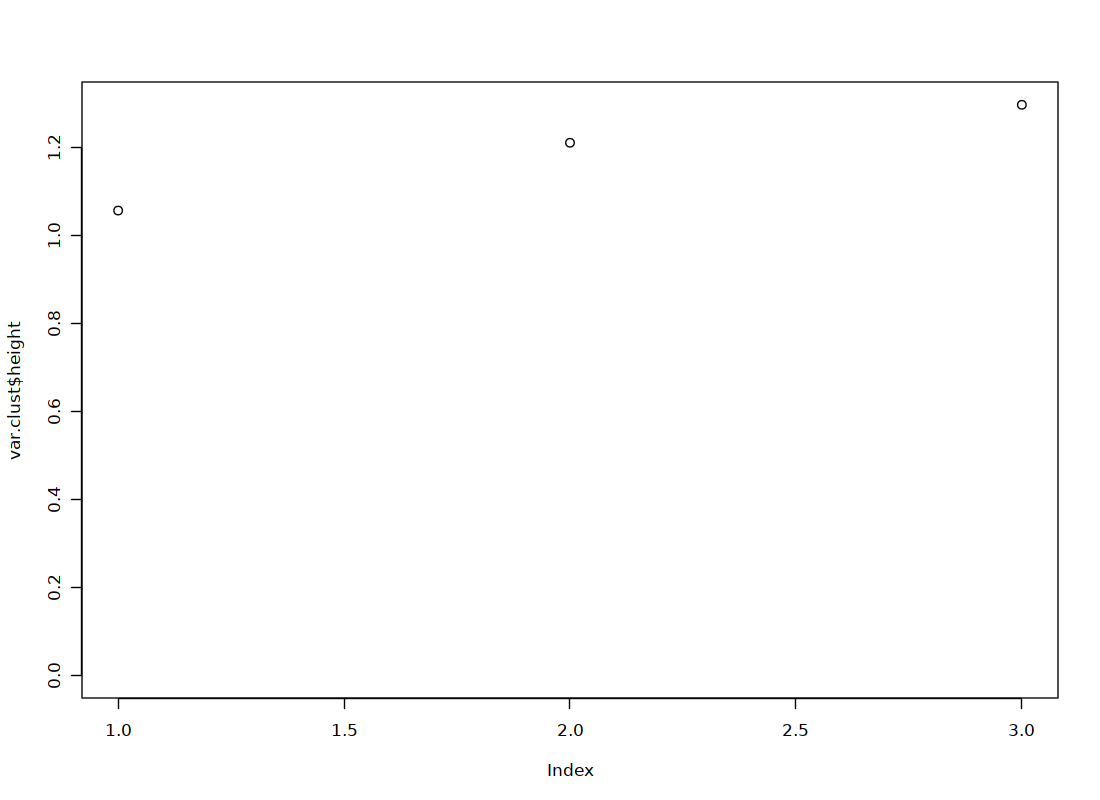

In [396]:
plot(var.clust$height, ylim = c(0, max(var.clust$height)))

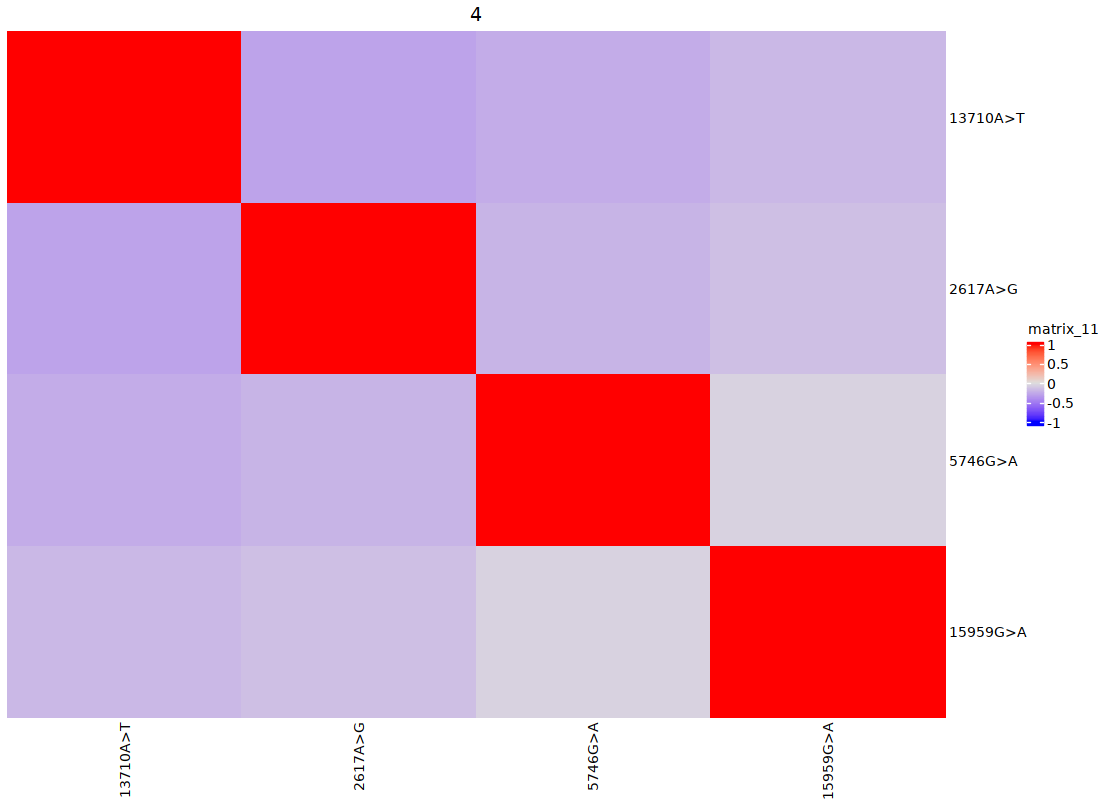

In [397]:

ngroups=length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

In [398]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

In [399]:
identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



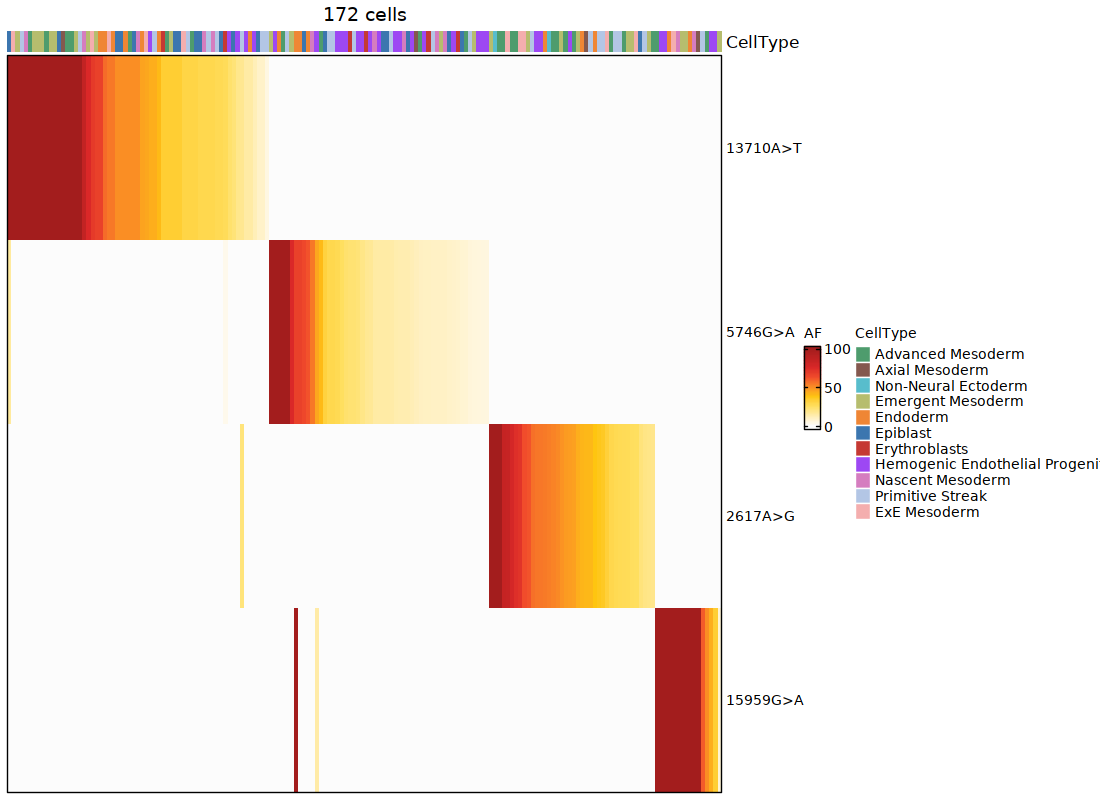

In [400]:
#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

meta.tib = as_tibble(meta[rownames(meta) %in% colnames(af.dm),])
meta.tib$cell = rownames(meta[rownames(meta) %in% colnames(af.dm),])
annot.tib = tibble(cell = colnames(plot_order.mat)) %>% left_join(meta.tib, by = "cell") %>% select(CellType)
ct_plot_df = data.frame(annot.tib)
ct_plot_df$CellType = factor(ct_plot_df$CellType, levels = type_list)
ha <- HeatmapAnnotation(df = ct_plot_df, col = ann_col)
options(repr.plot.width =11, reper.plot.height = 10)
#plot_order.mat[plot_order.mat>20] = 20
p1 = Heatmap(plot_order.mat, column_title = paste0(ncol(plot_order.mat)," cells"), 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               top_annotation = ha,
               border = T,
               #width = unit(120, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
p1



In [247]:
pdf("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_4clones_CIV_heatmap.pdf", height = 2, width = 6)
p1
dev.off()

png 
  2

In [401]:
tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }

CIV = unlist(Groups.tib$vars)
right_end = sapply(CIV, function(x) tail(which(plot_order.mat[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
clone_info_df = data.frame(Cell = colnames(plot_order.mat), Clone = rep(CIV, cell_num))
write.csv(clone_info_df, file = "/syn1/wangxin/work/SS2/embryo/CIV/embryo_CIV_clones.csv", quote = F, row.names = F)
message("Clone info has been saved to /syn1/wangxin/work/SS2/embryo/CIV/embryo_CIV_clones.csv")


Clone info has been saved to /syn1/wangxin/work/SS2/embryo/CIV/embryo_CIV_clones.csv



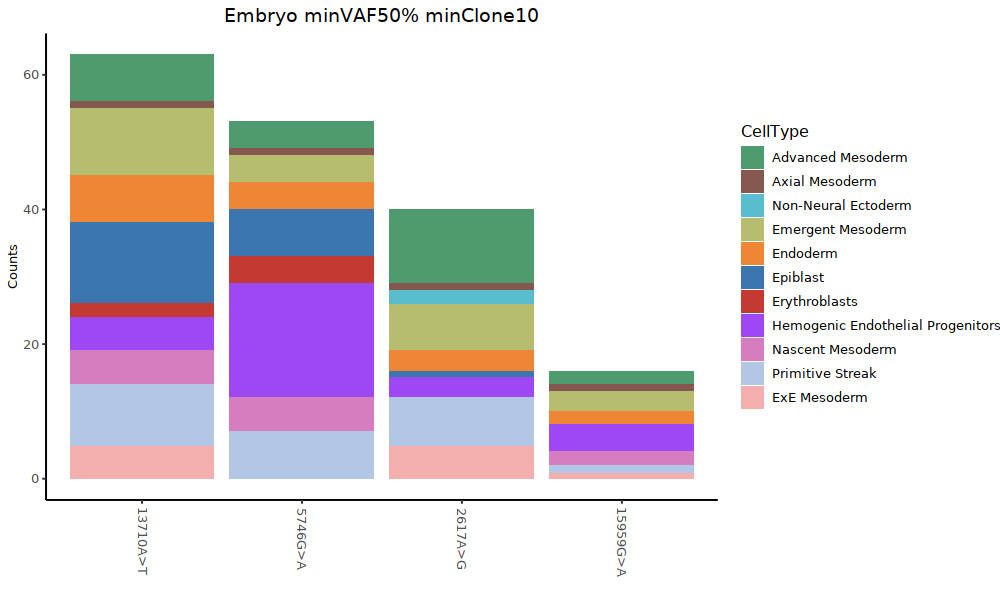

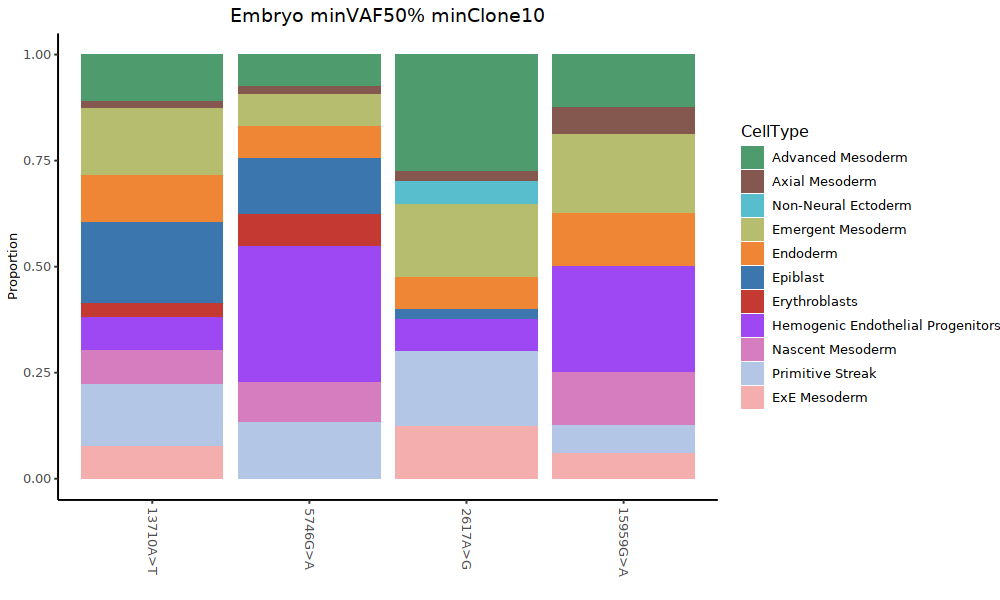

In [201]:
#meta = read.csv("/data/wangxin/work/MT_bm/10x/archr/Pooled_Donor1_PBMC_meta.csv", row.names=1)
ct_df = data.frame(matrix(nrow=0, ncol=4)) 
for (i in rownames(plot_order.mat)) {
    tmp_ct_df = as.data.frame(table(meta[clone_info_df$Cell[clone_info_df$Clone == i],"CellType"]))
    tmp_ct_df$Proportion = tmp_ct_df[,2]/sum(tmp_ct_df[,2])
    tmp_ct_df$Clone = i
    ct_df = rbind(ct_df, tmp_ct_df)
}

colnames(ct_df) = c("CellType", "Counts", "Proportion", "Clone")
#ct1 = c('Naive_B', 'Memory_B', 'CD4T_Naive', 'CD4T_Memory', 'CD8T_Naive', 'CD8T_Memory', 'NK', 
#                                        'CD14_Monocytes','CD16_Monocytes', 'cDC', 'pDC', 'Basophils')
ct_df$CellType = factor(ct_df$CellType, levels = type_list)
ct_df$Clone = factor(ct_df$Clone, levels = rownames(plot_order.mat) )

#pal1 = c('#D51F26','#272E6A','#89288F','#F47D2B','#FEE500','#8A9FD1','#C06CAB','#D8A767','#90D5E4','#89C75F','#F37B7D','#9983BD')
pal1 = ann_col$CellType

p2 = ggplot(ct_df, aes(x=Clone, y=Counts, fill=CellType)) + geom_bar(stat = "identity") + labs(title = "Embryo minVAF50% minClone10") + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 9), axis.title = element_text(size=9),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5)) + scale_fill_manual(values=pal1) + xlab("")
p2
p3 = ggplot(ct_df, aes(x=Clone, y=Proportion, fill=CellType)) + geom_bar(stat = "identity") + labs(title = "Embryo minVAF50% minClone10") + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 9), axis.title = element_text(size=9),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5)) + scale_fill_manual(values=pal1) + xlab("")
p3

In [202]:
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_celltype_comp_early.pdf", p3, height = 2.1, width = 5)

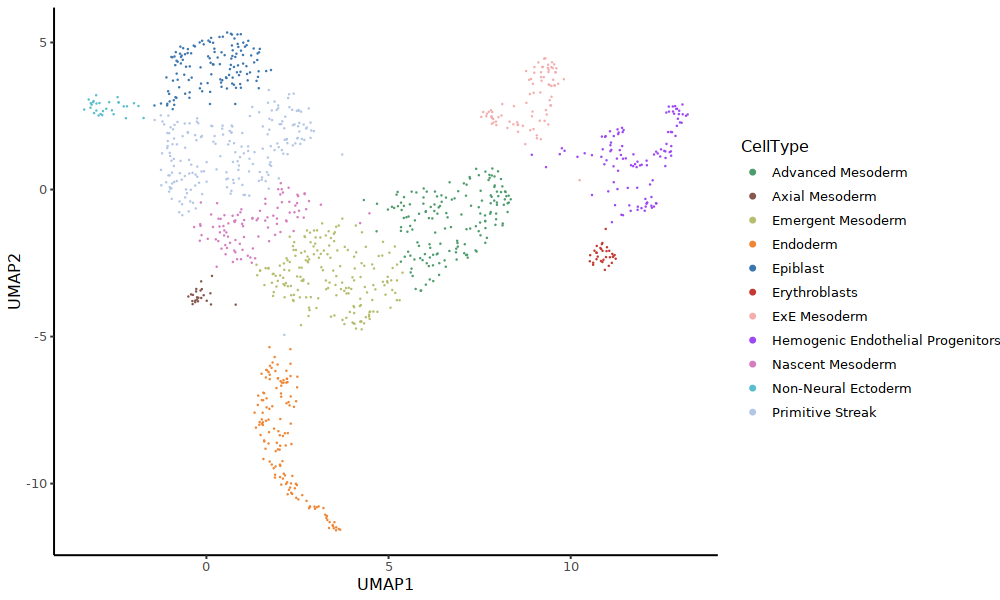

In [252]:
meta_df = read.csv("/data/wangxin/work/MT_bm/SS2/embryo/embryo_d16_meta.csv", check.names = F, row.names=1, header=T)

p4 = ggplot(meta_df, aes(x=UMAP1, y=UMAP2, color = CellType)) + geom_point(size=0.5, stroke = 0 ) + theme_classic() + scale_color_manual(values=pal1) +
    guides(colour = guide_legend(override.aes = list(size=2)))
p4
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP.pdf", p4, height = 2.1, width = 5)

In [255]:
meta_df$Clone = "Other"
for (i in CIV) {
    meta_df[clone_info_df$Cell[clone_info_df$Clone == i], "Clone"] = i
    }
meta_df = meta_df[rev(order(meta_df$Clone)),]
#meta_df$Clone = factor(meta_df$Clone, levels = CIV)

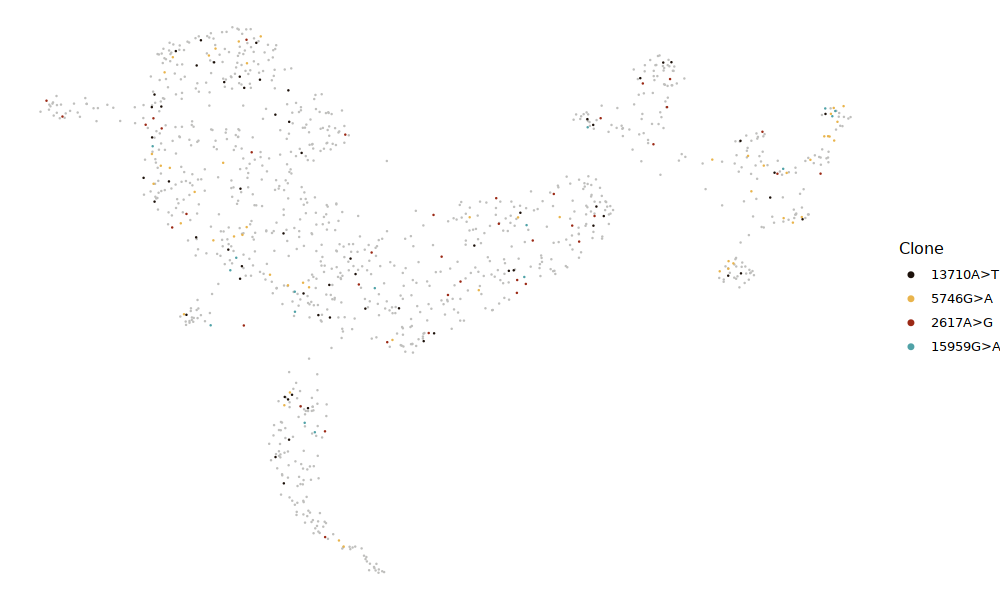

In [259]:
options(repr.plot.width=10, repr.plot.height=6)
new_pal = c("#1c110a", "#e9b44c", "#9b2915", "#50a2a7", "#BFBFBD")
names(new_pal) = c(CIV, "Other")
p4 = ggplot(meta_df, aes(x=UMAP1, y=UMAP2, color = Clone)) + geom_point(size=0.5, stroke = 0) + theme_void() + scale_color_manual(values = new_pal, breaks = CIV) + 
    guides(colour = guide_legend(override.aes = list(size=2)))
p4

ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP_legend.pdf", p4, height = 2, width = 3)

In [325]:

common_cells = intersect( colnames(af.dm), rownames(meta_df))
length(common_cells)

[1] 1183

In [257]:
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP_legend.pdf", p4, height = 2, width = 3)

In [39]:
p5 = ggplot(umap_plot_df, aes(x=UMAP1, y=UMAP2, color = CellType)) + geom_point(size=0.05) + theme_classic() + scale_color_manual(values=pal1) +
      theme(legend.position = "none")
ggsave("/syn1/wangxin/work/SS2/embryo/CIV/plots/embryo_UMAP_nolegend.pdf", p5, height = 1.5, width = 1.5)

In [74]:
common_cells = intersect( colnames(af.dm), rownames(meta_df))

file saved to /data/wangxin/src/notebook/SS2/CIV_cells_on_UMAP.pdf



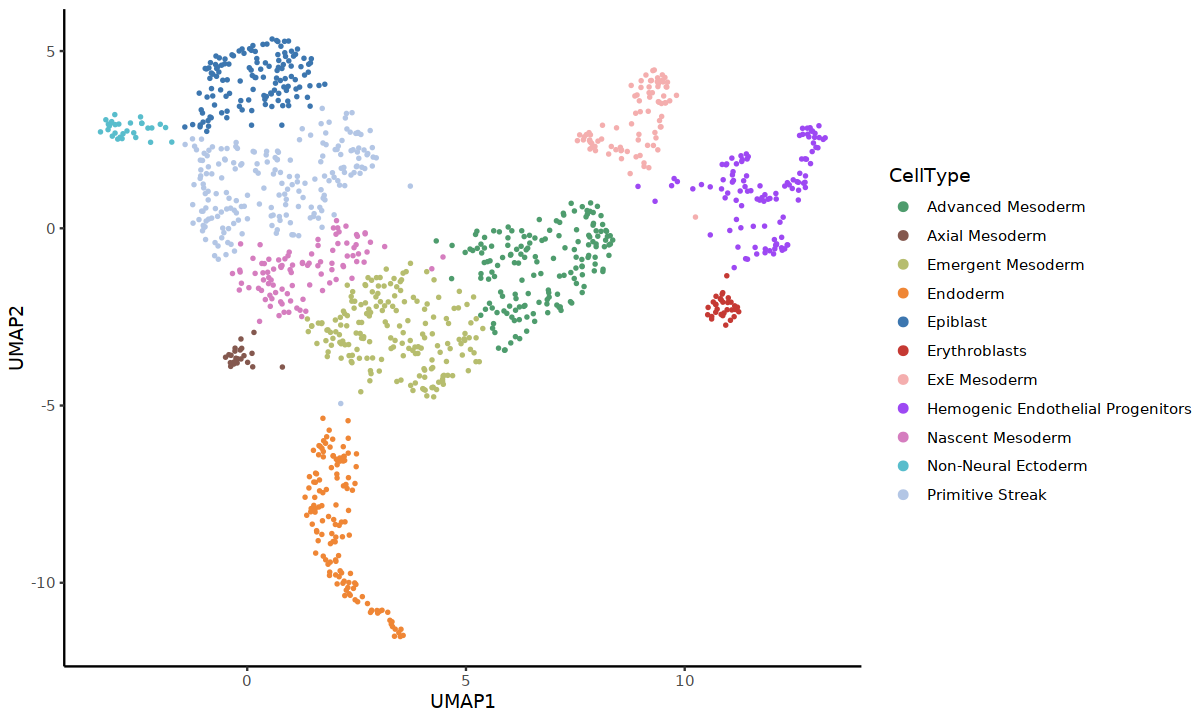

In [95]:
meta_df = read.csv("/data/wangxin/work/MT_bm/SS2/embryo/embryo_d16_meta.csv", check.names = F, row.names=1, header=T)

options(repr.plot.width=10, repr.plot.height=6)
common_cells = intersect( colnames(af.dm), rownames(meta_df))
af_ol.dm = af.dm[,common_cells]
umap_plot_df = meta_df[common_cells,]
ggplot(umap_plot_df, aes(x=UMAP1, y=UMAP2, color = CellType)) + geom_point(size=0.5) + theme_classic() + scale_color_manual(values=pal1) +
    guides(colour = guide_legend(override.aes = list(size=2)))

plot_ls = list()

for (i in rownames(plot_order.mat)) {
    umap_plot_df[,i] = af_ol.dm[i, ]
    umap_plot_df = umap_plot_df[order(umap_plot_df[,i]),]
    plot_ls[[i]]=ggplot(umap_plot_df, aes(x=UMAP1, y=UMAP2, color=!!sym(i))) + geom_point( size=0.3) + theme_classic() + scale_color_continuous(low="grey", high="red") + 
        theme(legend.position = "none") + labs(title = i)
}

ggexport(plotlist = plot_ls, nrow = 2, ncol =2, filename = "/data/wangxin/src/notebook/SS2/CIV_cells_on_UMAP.pdf", width = 6, height = 6)

In [402]:
out_dir = "/syn1/wangxin/work/SS2/embryo"
sample_name = "embryo"
new_plot_mat1 = plot_order.mat/100 
all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()

rv_all_ls = c()
rv_sub_ls = c()

cv_all_ls = c()
cv_sub_ls = c()

for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        rv = mean(tmp_vaf_ls)/var(tmp_vaf_ls)
        rv_all_ls = append(rv_all_ls, rv)
        cv_all_ls = append(cv_all_ls, sd(tmp_vaf_ls)/mean(tmp_vaf_ls))
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        rv = mean(tmp_vaf_ls)/var(tmp_vaf_ls)
        rv_sub_ls = append(rv_sub_ls, rv)
        cv_sub_ls = append(cv_sub_ls, sd(tmp_vaf_ls)/mean(tmp_vaf_ls))
}

rv_df_all = data.frame("Clone" = CIV, "RV" = rv_all_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
rv_df_sub = data.frame("Clone" = CIV, "RV" = rv_sub_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))
meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))
cv_df_all = data.frame("Clone" = CIV, "CV" = cv_all_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("All", length(CIV)))
cv_df_sub = data.frame("Clone" = CIV, "CV" = cv_sub_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("Sub", length(CIV)))

rv_df = rbind(rv_df_all, rv_df_sub)
rv_file_name = paste0(out_dir,"/CIV/rv_CIV_", sample_name, ".csv")
write.csv(rv_df, file = rv_file_name, quote = F, row.names = F)
message("Ralative variance info has been saved to: ", rv_file_name)


meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean and variance info have been saved to: ", meanvar_file_name)

cv_df = rbind(cv_df_all, cv_df_sub)
cv_file_name = paste0(out_dir,"/CIV/cv_CIV_", sample_name, ".csv")
write.csv(cv_df, file = cv_file_name, quote = F, row.names = F)
message("Ralative variance info has been saved to: ", cv_file_name)

Ralative variance info has been saved to: /syn1/wangxin/work/SS2/embryo/CIV/rv_CIV_embryo.csv

Mean and variance info have been saved to: /syn1/wangxin/work/SS2/embryo/CIV/meanvar_CIV_embryo.csv

Ralative variance info has been saved to: /syn1/wangxin/work/SS2/embryo/CIV/cv_CIV_embryo.csv



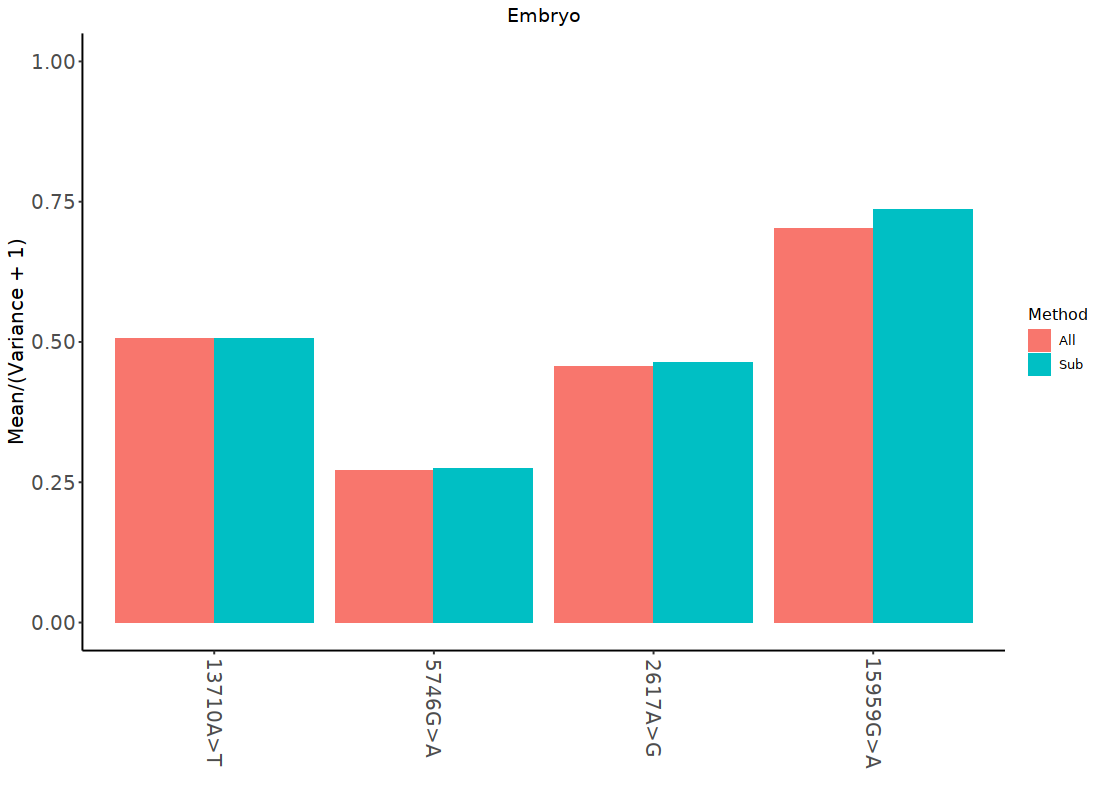

In [404]:
meanvar_df$Clone = factor(meanvar_df$Clone, levels = CIV)
ggplot(meanvar_df, aes(x=Clone, y=Mean/(Variance+1), fill=Method)) + geom_bar(stat = "identity", position = "dodge") + labs(title = "Embryo") + theme_classic() +
        theme(plot.title=element_text(hjust=0.5), axis.text = element_text(size = 14), axis.title = element_text(size=14),
        axis.text.x = element_text(angle = 270, hjust = 0.1, vjust = 0.5)) +  xlab("") + ylim (0, 1)

[1] 0.1

# T cell

In [326]:
umap_meta = read.csv("/syn1/wangxin/work/SS2/Li/new_tcr_meta.csv", row.names = 1, check.names = F)
umap_meta$cluster_id = factor(umap_meta$cluster_id, levels = 1:6)

In [ ]:
umap_meta

In [327]:
col_pal = sample(col_pal)
p_umap = ggplot(umap_meta, aes(x=UMAP_1, y=UMAP_2, color = cluster_id)) + geom_point(size=0.5, stroke = 0) + theme_classic() + scale_color_manual(values = col_pal) + 
    guides(colour = guide_legend(override.aes = list(size=2)))
p_umap
ggsave(p_umap, filename = "/syn1/wangxin/work/SS2/Li/plots/umap_all_T_cells.pdf", width = 3, height = 2)


ERROR: Error in x[sample.int(length(x), size, replace, prob)]: object of type 'closure' is not subsettable


In [312]:
print(col_pal)

 [1] "#3d348b" "#f9844a" "#90be6d" "#577590" "#e9c46a" "#f94144" "#606c38"
 [8] "#2a9d8f" "#264653" "#778da9" "#e36414" "#0f4c5c" "#e4c1f9" "#43aa8b"
[15] "#dda15e" "#f3722c" "#fefae0" "#277da1" "#a9def9" "#e0e1dd" "#33a1fd"
[22] "#ffdac6" "#9a031e" "#e9f5db" "#283618" "#1b263b" "#415a77" "#bc6c25"
[29] "#f9c74f" "#d0f4de" "#7678ed" "#f8961e" "#5f0f40" "#c0d6df" "#4d908e"
[36] "#7cb518" "#e76f51"


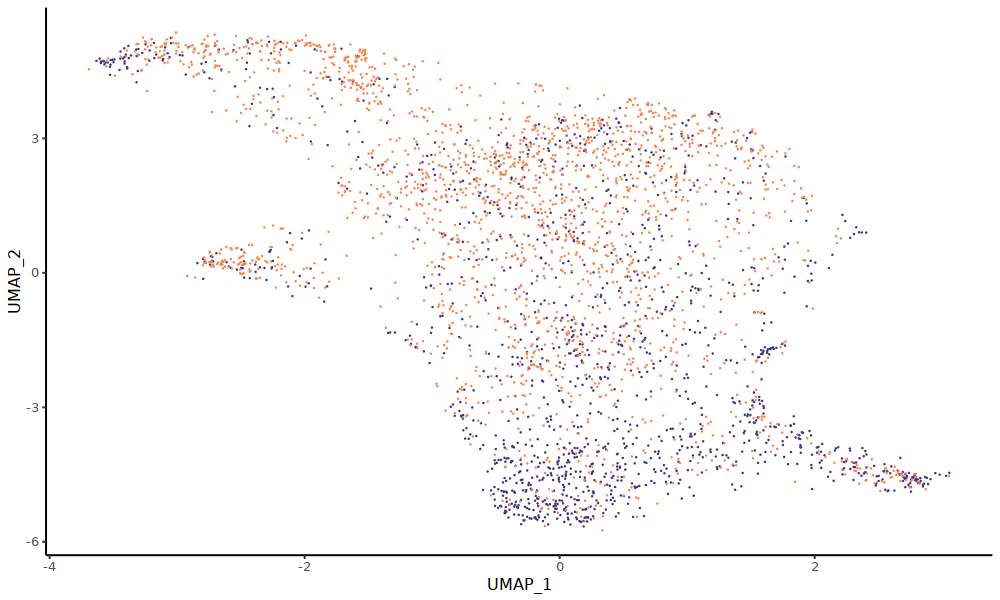

In [316]:
expan_umap = ggplot(umap_meta, aes(x=UMAP_1, y=UMAP_2, color = expanded)) + geom_point(size=0.5, stroke = 0) + theme_classic() + scale_color_manual(values = rev(col_pal[1:2])) + 
    theme(legend.position = "none")
expan_umap
ggsave(expan_umap, filename = "/syn1/wangxin/work/SS2/Li/plots/umap_all_T_cells_expansion.pdf", width = 2, height = 2)

## MS0816

In [102]:
main_dir = "/syn1/wangxin/work/SS2/Li/samples/"
simul_id = "MS0816"
df_file = paste0(main_dir, simul_id, "/outs_vc1/", simul_id, "_mtSNV_final.csv")
df = read.csv(df_file, row.names = 1, check.names = F)

tcr_meta = read.csv("/syn1/wangxin/work/SS2/Li/new_tcr_meta.csv", check.names = F, row.names = 1)
sub_cells = intersect(colnames(df), rownames(tcr_meta))

af.dm = as.matrix(df[,sub_cells]*100)
af.dm[af.dm<5] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
#vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Test different variant selection thresholds #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Specify variant selection thresholds to test. voi = variant of interest
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 4),
                         min_vaf = rep(c("n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code
        
        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}
conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls
conditions.tib

Time difference of 0.07802391 secs

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"1351G>A,....",18,SRR17557....,160,0.7777778
6,n5,"1351G>A,....",15,SRR17557....,151,0.8000000
7,n5,"2129G>A,....",12,SRR17557....,138,0.7500000
8,n5,"2129G>A,....",11,SRR17557....,138,0.7272727
9,n5,"2129G>A,....",10,SRR17557....,131,0.7000000
10,n5,"2129G>A,....",9,SRR17557....,129,0.6666667
5,n10,"2464G>A,....",9,SRR17557....,119,0.6666667
6,n10,"2464G>A,....",8,SRR17557....,112,0.6250000
7,n10,"2464G>A,....",6,SRR17557....,103,0.5000000


In [103]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5", "n10","n20","n50"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"1351G>A,....",18,SRR17557....,160,0.7777778
10,n5,"2129G>A,....",9,SRR17557....,129,0.6666667
5,n10,"2464G>A,....",9,SRR17557....,119,0.6666667
10,n10,"3202T>A,....",3,SRR17557....,59,0.3333333
5,n20,"7882A>T,....",2,SRR17557....,35,0.5000000
10,n20,16362T>C,1,SRR17557....,18,1.0000000
5,n50,16362T>C,1,SRR17557....,18,1.0000000
10,n50,16362T>C,1,SRR17557....,18,1.0000000


In [104]:
# 6. Select variants present in at least 50 cells with a VAF of >20%

a=1
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



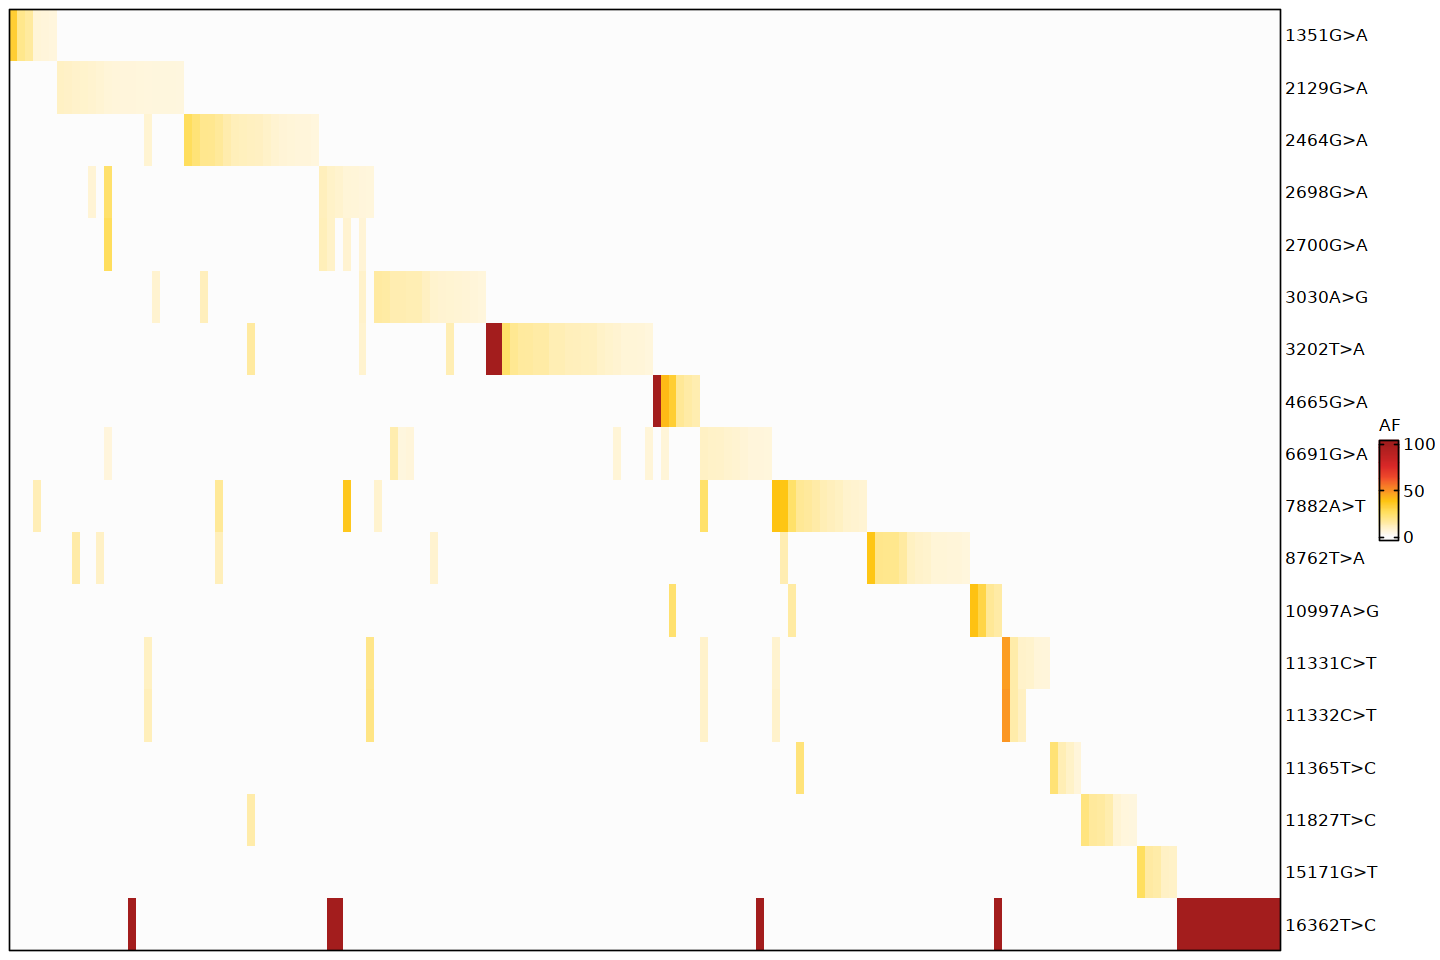

In [105]:
#options(repr.plot.width=16, repr.plot.height=12)
Heatmap(plot_order.mat,
              col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                               c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
              show_row_names = ifelse(nrow(plot_order.mat) < 100, T, F),
              show_column_names = F,
              cluster_columns = F,
              cluster_rows = F,
              row_names_gp = gpar(fontsize = 10),
              name = "AF",
              heatmap_legend_param = list(border = "#000000", grid_height = unit(10, "mm")),
              #top_annotation = ha,
              border = T,
              #width = unit(250, "mm"),
              #height = unit(120, "mm"),
              use_raster = T,
              raster_quality = 5)

In [106]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

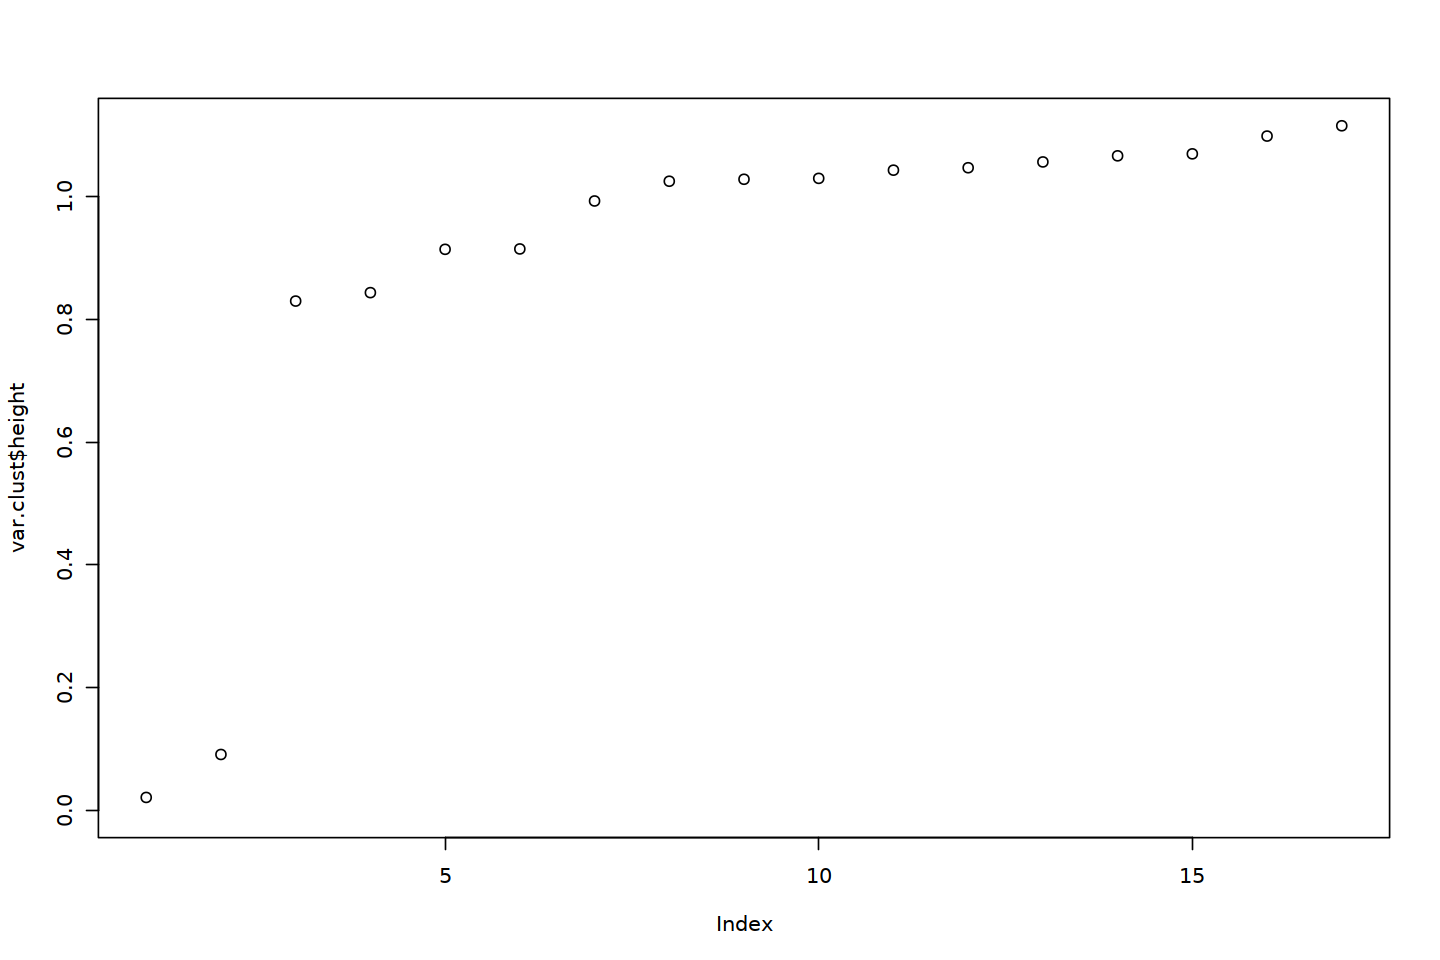

In [107]:
plot(var.clust$height, ylim = c(0, max(var.clust$height)))

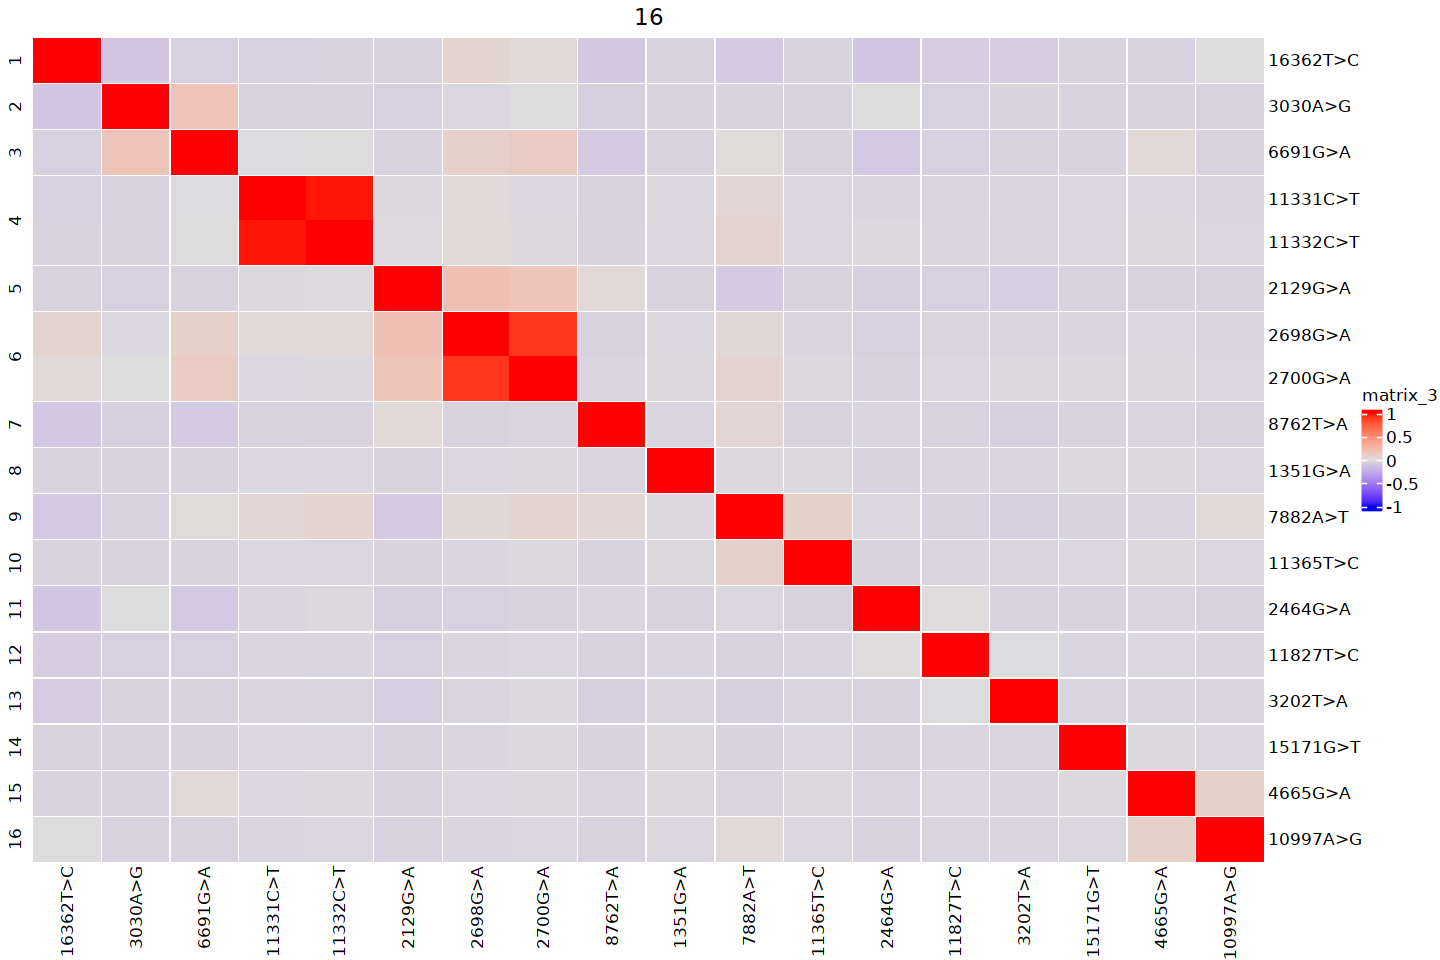

In [108]:

ngroups=length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

[1] TRUE

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



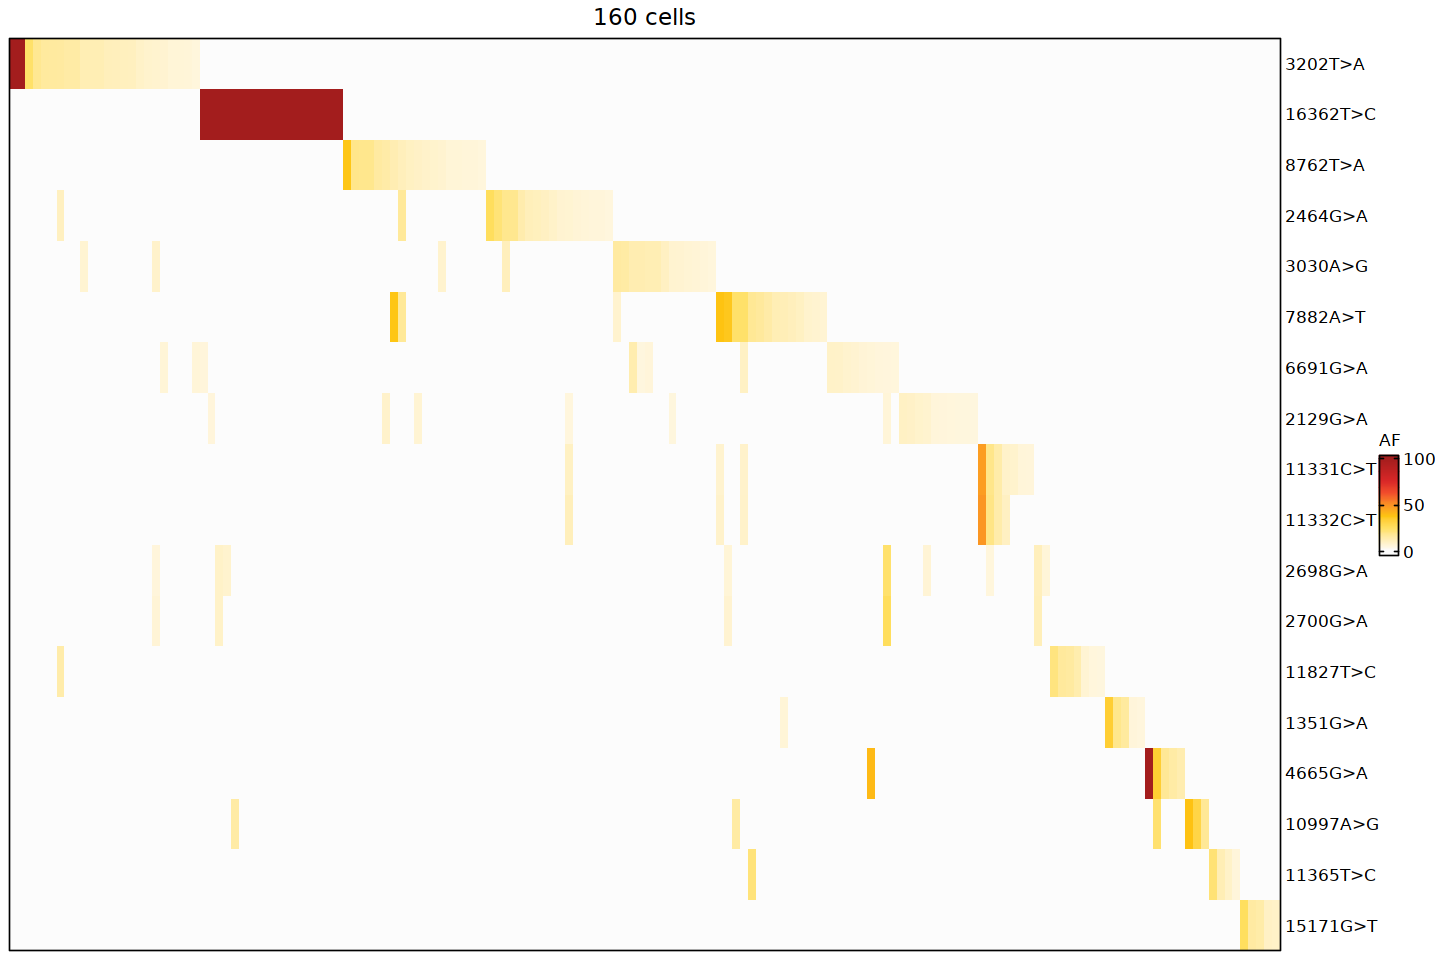

In [109]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

Heatmap(plot_order.mat, column_title = paste0(ncol(plot_order.mat)," cells"), 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

Clone info has been saved to /syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/CIV_clones_MS0816.csv

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



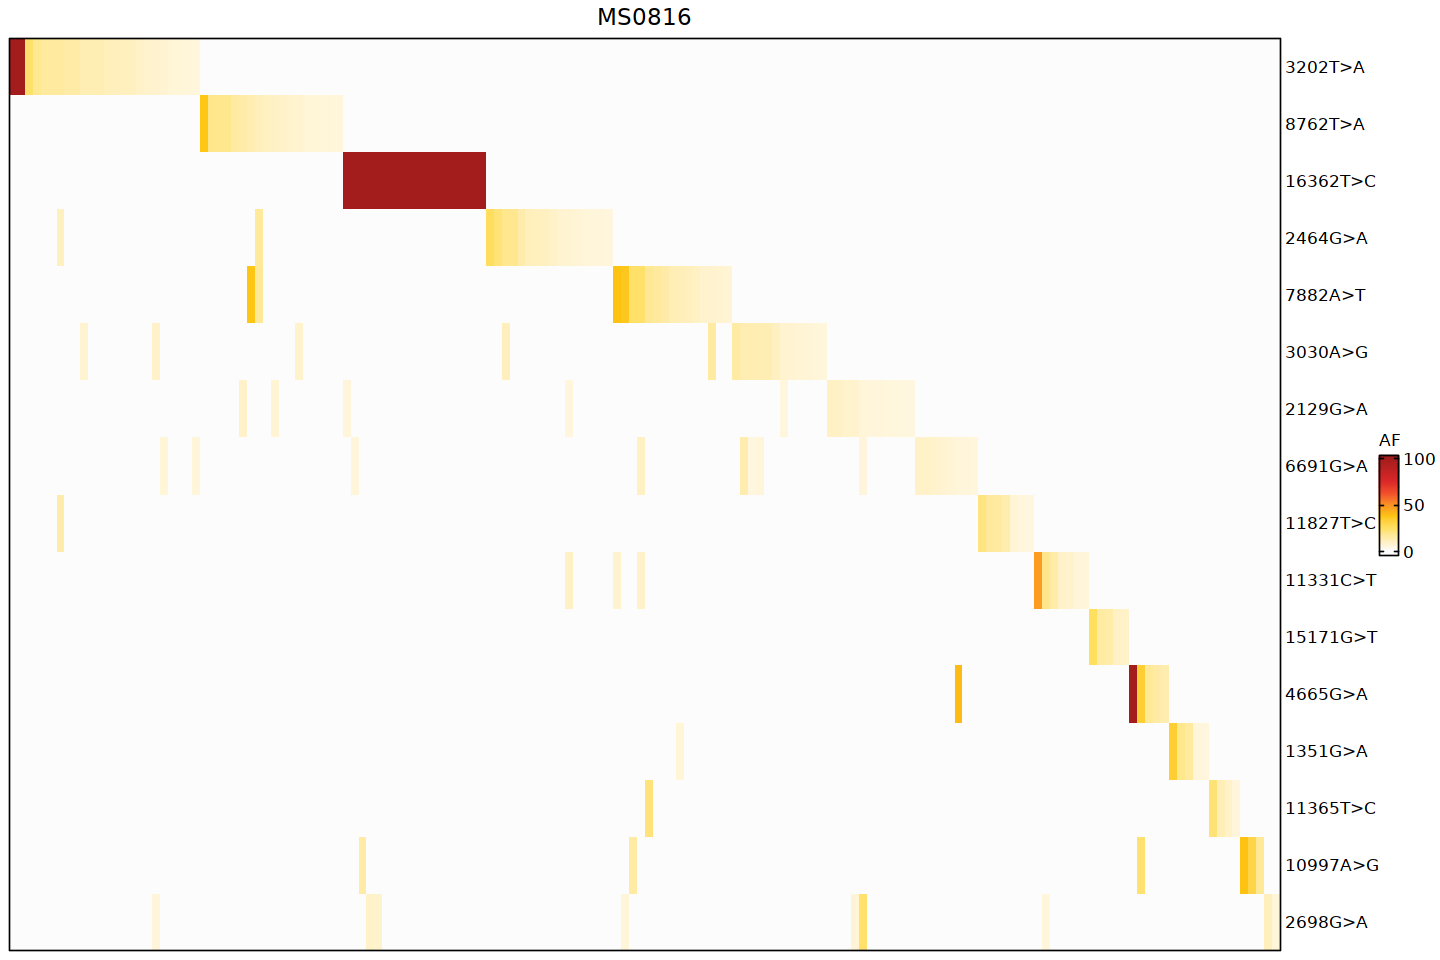

In [110]:
tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))
write.csv(clone_info_df, file = paste0("/syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/CIV_clones_MS0816.csv"), quote = F, row.names = F)
message("Clone info has been saved to ", paste0("/syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/CIV_clones_MS0816.csv"))

new_plot_mat = new2
                                   
htmap_p = Heatmap(new_plot_mat, column_title = simul_id, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p
                       

In [112]:
TCR_df = data.frame("TCR" = tcr_meta[colnames(new_plot_mat), "CDR3b"], row.names = colnames(new_plot_mat))
TCR_seq = unique(TCR_df$TCR)

In [136]:
saveRDS(file = "/syn1/wangxin/work/SS2/Li/plots/col_pal_fig2_SS2_TCR_MS0816_20240419.rds", col_pal)

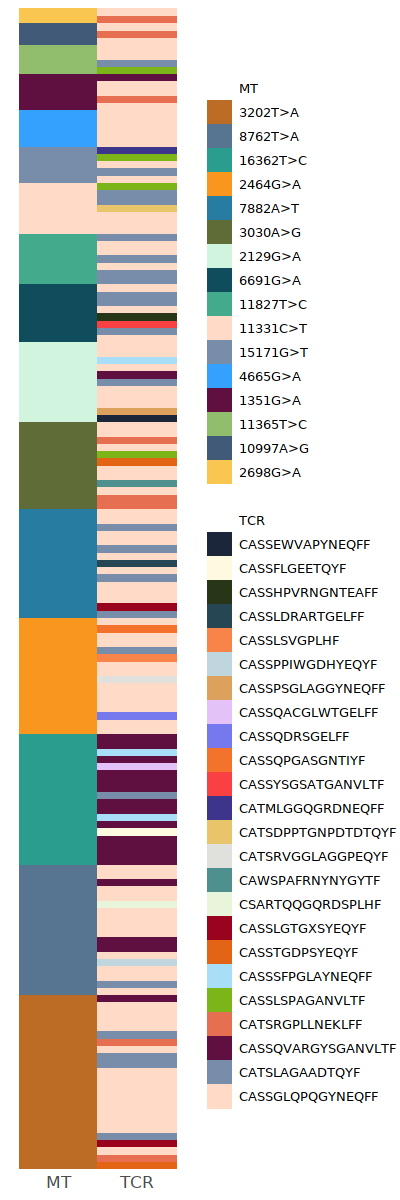

In [219]:
options(repr.plot.width = 4, repr.plot.height = 12, repr.plot.res = 100)
col_pal = sample(col_pal)
#col_pal = readRDS( "/syn1/wangxin/work/SS2/Li/plots/col_pal_fig2_SS2_TCR_20240419.rds")

TCR_df = data.frame("TCR" = tcr_meta[colnames(new_plot_mat), "CDR3b"], row.names = colnames(new_plot_mat))
TCR_seq = unique(TCR_df$TCR)


bar_plot_df = cbind(clone_info_df, TCR_df)
TCR_freq_df = as.data.frame(table(bar_plot_df$TCR))
TCR_order = as.character(TCR_freq_df[order(TCR_freq_df$Freq),"Var1"])
mt_order = unique(bar_plot_df$Clone)


df_log = pivot_longer(bar_plot_df, cols = c("Clone", "TCR"), names_to = "Variable", values_to = "Value")
df_log$Cell = factor(df_log$Cell, levels = colnames(new_plot_mat))
legend_order = c("MT", mt_order, " ","TCR", TCR_order)
df_log$Value = factor(df_log$Value, levels = legend_order)


# Create a color palette
pal1 <- c("white", col_pal[1:length(mt_order)], "white", "white", col_pal[(length(mt_order)+1):(length(mt_order)+length(TCR_order))])
names(pal1) = legend_order

if (length(mt_order)+length(TCR_order) > length(col_pal)) {
    extra_col_num = length(mt_order) + length(TCR_order) - length(col_pal)
    pal1[legend_order[(length(col_pal)+1+3): (length(col_pal) + extra_col_num+3)]] = sample(col_pal[1:length(mt_order)], extra_col_num)
    }


# Plot the stacked bar plot with "CLL" on the y-axis
p = ggplot(df_log, aes(x = Variable, y = Cell, fill = Value)) +
  geom_tile() +
  scale_fill_manual(name = NULL,values = pal1, drop=FALSE) +   guides(fill=guide_legend(ncol=1)) +
   theme(legend.position="right", 
         legend.key = element_rect(fill=NA),
         legend.title=element_blank()) + theme_classic() +
          theme(axis.text.y = element_blank(),
            axis.ticks = element_blank(),
            axis.title.y = element_blank(), axis.title.x = element_blank(), axis.text.x = element_text(size = 12, face = "italic"), axis.line = element_blank()) + 
            scale_x_discrete(breaks=c("Clone","TCR"), labels=c("MT", "TCR"))
p
ggsave("/syn1/wangxin/work/SS2/Li/plots/MS0816_MT_to_TCR_correlation.pdf", p, height = 4, width = 4)

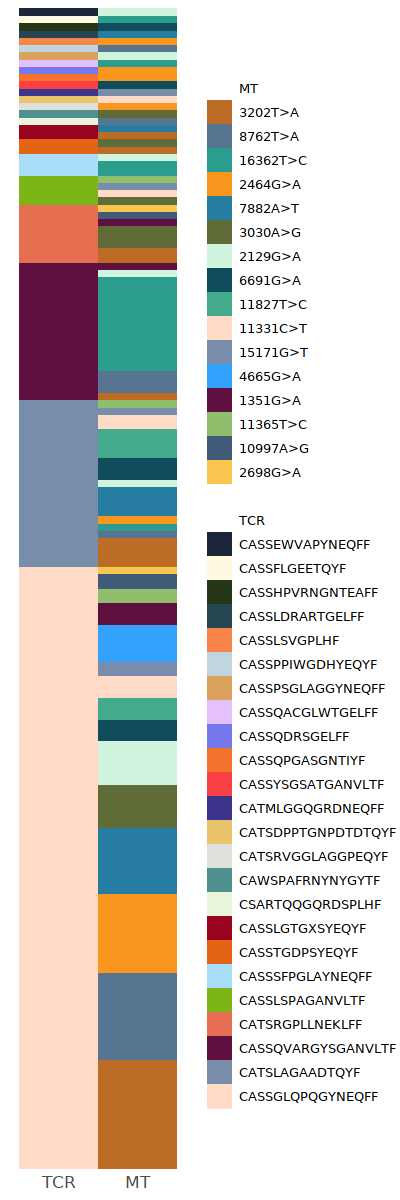

In [220]:
cell_order_by_TCR = bar_plot_df$Cell[order(match(bar_plot_df$TCR, rev(TCR_order)))]
df_log2 = pivot_longer(bar_plot_df, cols = c("Clone", "TCR"), names_to = "Variable", values_to = "Value")
df_log2 = df_log2[order(match(df_log2$Cell, cell_order_by_TCR)),]
df_log2$Cell = factor(df_log2$Cell, levels = cell_order_by_TCR)

legend_order = c("MT", mt_order, " ","TCR", TCR_order)
df_log2$Value = factor(df_log2$Value, levels = legend_order)

df_log2$Variable = factor(df_log2$Variable, levels = c("TCR", "Clone"))

p0 = ggplot(df_log2, aes(x = Variable, y = Cell, fill = Value)) +
  geom_tile() +
  scale_fill_manual(name = NULL,values = pal1, drop=FALSE) + guides(fill=guide_legend(ncol=1)) +
   theme(legend.position="right", 
         legend.key = element_rect(fill=NA),
         legend.title=element_blank()) + theme_classic() +
          theme(axis.text.y = element_blank(),
            axis.ticks = element_blank(),
            axis.title.y = element_blank(), axis.title.x = element_blank(), axis.text.x = element_text(size = 12, face = "bold"), axis.line = element_blank()) + 
            scale_x_discrete(breaks=c("TCR","Clone"), labels=c("TCR", "MT"))
ggsave("/syn1/wangxin/work/SS2/Li/plots/MS0816_TCR_to_MT_correlation.pdf", p0, height = 4, width = 4)
p0

In [221]:

sample_name = "MS0816"
out_dir = paste0("/syn1/wangxin/work/SS2/Li/samples/", sample_name, "/")
new_plot_mat1 = new_plot_mat/100 
all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()


for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mean(tmp_vaf_ls)/(var(tmp_vaf_ls)+1))
        
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mean(tmp_vaf_ls)/(var(tmp_vaf_ls)+1))
        }

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))

meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean and variance info have been saved to: ", meanvar_file_name)


Mean and variance info have been saved to: /syn1/wangxin/work/SS2/Li/samples/MS0816//CIV/meanvar_CIV_MS0816.csv



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



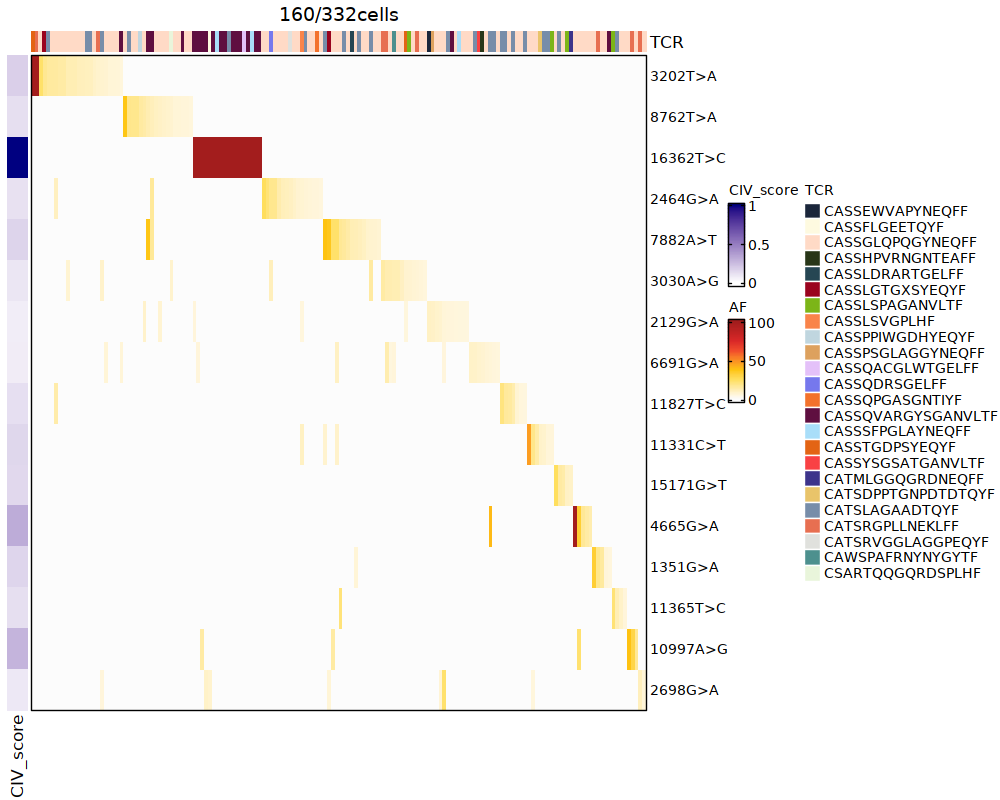

In [222]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)

#define annotation for cells
ann_col = list("TCR"=pal1[TCR_seq])
names(ann_col$TCR) = TCR_seq
ha = HeatmapAnnotation(df = TCR_df, col = ann_col)

#define annotation for CIVs
ra_pal = colorRamp2(c(0, 1), c( "white", "navyblue"))
row_annot <- rowAnnotation(
  df = data.frame(CIV_score = sub_mv1_ls),
  col = list(CIV_score = ra_pal), annotation_legend_param = list(border = "#000000"))

#new_plot_mat = new_plot_mat[c(1:9,11,13:nrow(new_plot_mat)),]
p1 = Heatmap(new_plot_mat, column_title = paste0(ncol(new_plot_mat),"/",length(sub_cells),"cells"), 
               col = colorRamp2(seq(0, round(max(new_plot_mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #left_annotation = row_annot,
               top_annotation = ha,
             left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
p1

In [223]:
pdf(paste0("/syn1/wangxin/work/SS2/Li/plots/MS0816_CIV_heatmap.pdf"), height = 2.645, width = 6)
p1
dev.off()

png 
  2

In [224]:
saveRDS(file = "/syn1/wangxin/work/SS2/Li/plots/col_pal_fig2_SS2_TCR_MS0816_20240419.rds", col_pal)

In [294]:
clone_info_df = read.csv("/syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/CIV_clones_MS0816.csv")

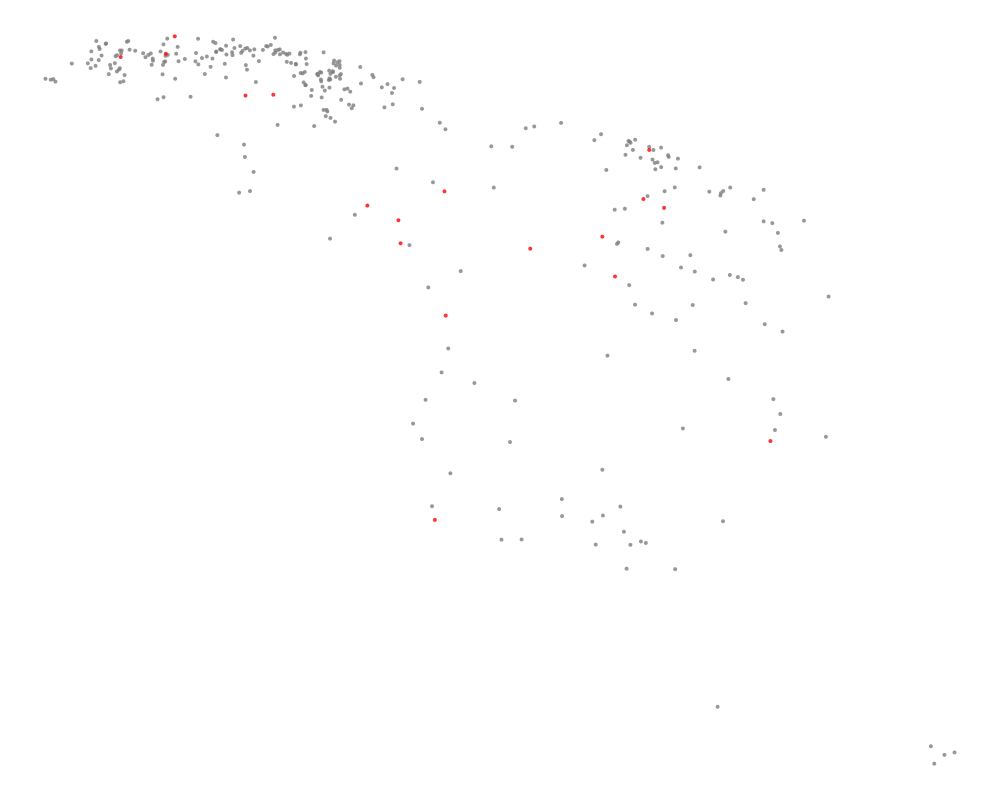

In [297]:
umap_meta = read.csv("/syn1/wangxin/work/SS2/Li/new_tcr_meta.csv", head=T, row.names = 1, check.names = F)
meta_sub = umap_meta[umap_meta$`patient ID` == "MS0816",]

new_meta = meta_sub[,c("UMAP_1", "UMAP_2", "CDR3b")]
clone_info_df = read.csv("/syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/CIV_clones_MS0816.csv")

new_meta$MT = NA
new_meta[clone_info_df$Cell[clone_info_df$Clone == "16362T>C"],"MT"] = "16362T>C"
new_meta = new_meta[rev(order(new_meta$MT)),]

p2 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = MT)) + geom_point(size=1, alpha= 0.8, stroke = 0 ) + theme_void() + scale_color_manual(values = c("red", "gray"))+ theme(legend.position = "none")
p2
ggsave("/syn1/wangxin/work/SS2/Li/plots/MS0816_MT_UMAP.pdf", p2, height = 2, width = 2)

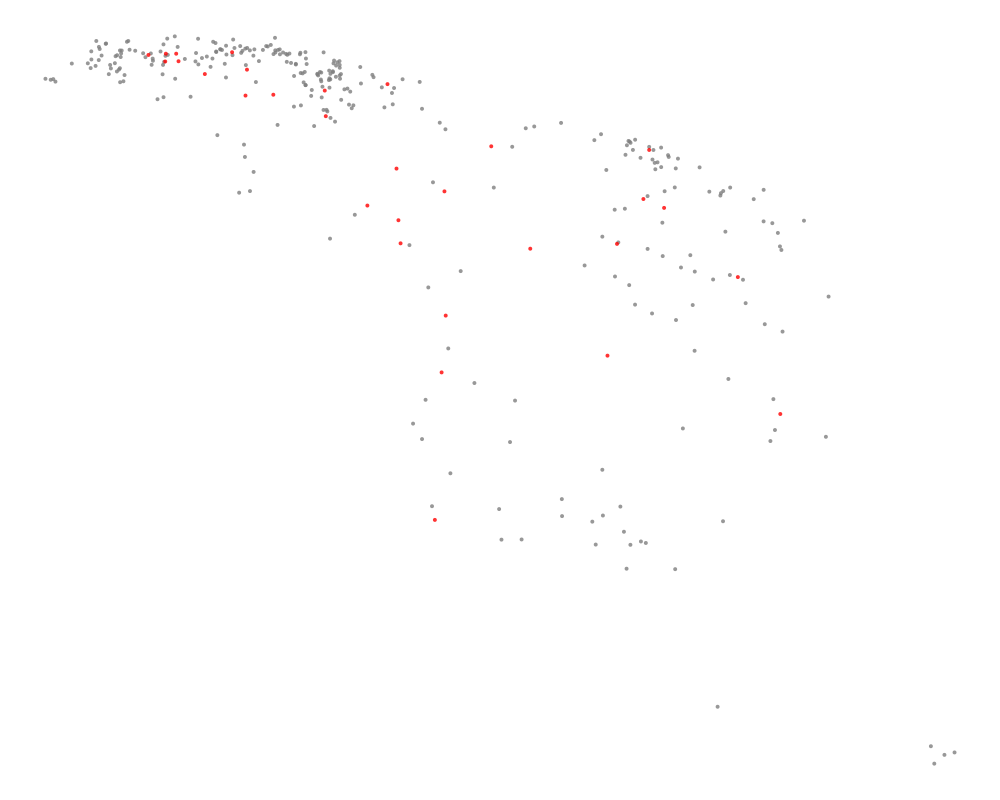

In [291]:
new_meta$TCR = NA
new_meta[new_meta$CDR3b == "CASSQVARGYSGANVLTF", "TCR"] =  "CASSQVARGYSGANVLTF"  
new_meta = new_meta[rev(order(new_meta$TCR)),]
p3 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = TCR)) + geom_point(size=1, alpha= 0.8,  stroke = 0) + theme_void() + scale_color_manual(values = c("red", "gray")) + theme(legend.position = "none")
p3
ggsave("/syn1/wangxin/work/SS2/Li/plots/MS0816_TCR_UMAP.pdf", p3, height = 2, width = 2)

## SLE232

In [225]:
main_dir = "/syn1/wangxin/work/SS2/Li/samples/"
simul_id = "SLE232"
df_file = paste0(main_dir, simul_id, "/outs_vc1/", simul_id, "_mtSNV_final.csv")
df = read.csv(df_file, row.names = 1, check.names = F)

tcr_meta = read.csv("/syn1/wangxin/work/SS2/Li/new_tcr_meta.csv", check.names = F, row.names = 1)
sub_cells = intersect(colnames(df), rownames(tcr_meta))

af.dm = as.matrix(df[,sub_cells]*100)
af.dm[af.dm<5] = 0
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm))

start_time <- Sys.time()
vars.tib = mutate(vars.tib, n0 = apply(af.dm, 1, function(x) sum(x == 0)))
#vars.tib = mutate(vars.tib, n1 = apply(af.dm, 1, function(x) sum(x >= 1)))
vars.tib = mutate(vars.tib, n5 = apply(af.dm, 1, function(x) sum(x >= 5)))
vars.tib = mutate(vars.tib, n10 = apply(af.dm, 1, function(x) sum(x >= 10)))
vars.tib = mutate(vars.tib, n20 = apply(af.dm, 1, function(x) sum(x >= 20)))
vars.tib = mutate(vars.tib, n50 = apply(af.dm, 1, function(x) sum(x >= 50)))
Sys.time() - start_time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Test different variant selection thresholds #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Specify variant selection thresholds to test. voi = variant of interest
conditions.tib <- tibble(min_clone_size = rep(seq(5, 10, by = 1), 4),
                         min_vaf = rep(c("n5", "n10", "n20", "n50"), each = 6),
                         vois = NA,
                         n_vois = NA,
                         cells = NA,
                         n_cells = NA,
                         transitions = NA)
vois.ls <- vector(mode = "list", length = nrow(conditions.tib))
cells.ls <- vector(mode = "list", length = nrow(conditions.tib))

vars_filter.tib <- vars.tib %>% filter(n0 > 0.9*ncol(af.dm)) # change this from 0.9 to 0.6 to include more variants
# Fill in conditions.tib
for (x in 1:nrow(conditions.tib)) {
    min_clone_size <- conditions.tib$min_clone_size[x]
    min_vaf <- conditions.tib$min_vaf[x]

    # Define variants of which the number of cells exceeding min_vaf is higher than min_clone_size
    voi.ch <- vars_filter.tib$var[vars_filter.tib[[min_vaf]] >= min_clone_size]
    #print(voi.ch)
    if (length(voi.ch) == 0) {
         # Add information to summary table
        conditions.tib[x,"n_vois"] <- 0
        conditions.tib[x,"n_cells"] <- NA
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- NA
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- NA
        #print(positive_cells)
        cells.ls[[x]] <- NA
    }
    else {
        #print(voi.ch)
        # Which cells are positive for at least one of the variants?
        af_subset.dm <- af.dm[voi.ch, ,drop = FALSE]
        positive_cells <- colnames( af_subset.dm[,colSums(af_subset.dm > 1) > 0 , drop = FALSE] ) # changed the original code
        
        # Add information to summary table
        conditions.tib[x,"n_vois"] <- length(voi.ch)
        conditions.tib[x,"n_cells"] <- length(positive_cells)
        # Transitions vs. transversions
        conditions.tib[x,"transitions"] <- mean( str_count(voi.ch, "G>A|A>G|C>T|T>C") )
        
        # Save variants and cells for these parameters
        vois.ls[[x]] <- voi.ch
        #print(positive_cells)
        cells.ls[[x]] <- positive_cells
        }
}
conditions.tib$vois <- vois.ls
conditions.tib$cells <- cells.ls
conditions.tib

Time difference of 0.04810667 secs

min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"664G>T, ....",20,SRR17557....,126,0.6000000
6,n5,"664G>T, ....",18,SRR17557....,120,0.6666667
7,n5,"664G>T, ....",16,SRR17557....,115,0.6875000
8,n5,"1201A>G,....",14,SRR17557....,109,0.7142857
9,n5,"2464G>A,....",12,SRR17557....,100,0.6666667
10,n5,"2464G>A,....",11,SRR17557....,93,0.7272727
5,n10,"1201A>G,....",13,SRR17557....,98,0.6923077
6,n10,"1201A>G,....",8,SRR17557....,88,0.7500000
7,n10,"1201A>G,....",7,SRR17557....,82,0.8571429


In [226]:
conditions_subset.tib <- conditions.tib %>% filter(min_clone_size %in% c(5, 10), min_vaf %in% c("n5", "n10","n20","n50"))
conditions_subset.tib


min_clone_size,min_vaf,vois,n_vois,cells,n_cells,transitions
<dbl>,<chr>,<list>,<int>,<list>,<int>,<dbl>
5,n5,"664G>T, ....",20,SRR17557....,126,0.6000000
10,n5,"2464G>A,....",11,SRR17557....,93,0.7272727
5,n10,"1201A>G,....",13,SRR17557....,98,0.6923077
10,n10,"2617A>G,....",2,SRR17557....,31,1.0000000
5,n20,"1201A>G,....",4,SRR17557....,45,1.0000000
10,n20,"2617A>G,....",2,SRR17557....,31,1.0000000
5,n50,"1201A>G,....",4,SRR17557....,45,1.0000000
10,n50,3849G>A,1,SRR17558....,14,1.0000000


In [227]:
# 6. Select variants present in at least 50 cells with a VAF of >20%

a=1
voi.ch <- conditions_subset.tib$vois[[a]]

# List cell IDs that are positive for each of the vois --------------------------------------------
positive_cells.ls <- list()
for (v in voi.ch) {
    # Determine cells with an appreciable VAF
    current_cells.ch <- colnames(af.dm)[af.dm[v,]>1]
    # Save cell IDs for positive cells
    positive_cells.ls[[v]] <- current_cells.ch
}
# Make a tibble of cells marked by each voi
positive_cells.tib <- as_tibble(bind_rows(lapply(positive_cells.ls, function(x) data.frame(cell = x)), .id = "variant")[,2:1]) %>%
    mutate(variant = factor(variant, levels = voi.ch))


# Prepare matrix of variants of interest in cells that are positive for at least one
af_voi.mat <- af.dm[voi.ch,]

af_subset.mat = af_voi.mat[, apply(af_voi.mat, 2, function(x) sum(x>1))>0]

# Customize column order. This is different from the strategy for K562 subclones.
plot_order.mat <- af_subset.mat
for (x in rev(voi.ch)) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }
#for (x in voi.ch) { plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])] }

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



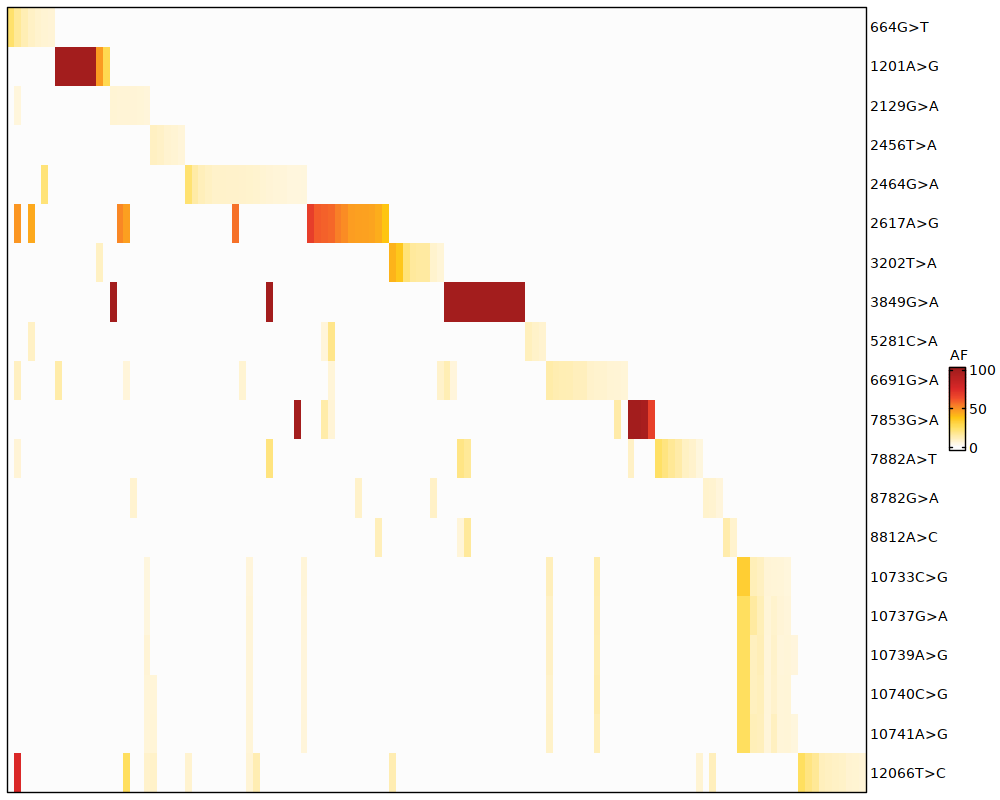

In [228]:
#options(repr.plot.width=16, repr.plot.height=12)
Heatmap(plot_order.mat,
              col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                               c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
              show_row_names = ifelse(nrow(plot_order.mat) < 100, T, F),
              show_column_names = F,
              cluster_columns = F,
              cluster_rows = F,
              row_names_gp = gpar(fontsize = 10),
              name = "AF",
              heatmap_legend_param = list(border = "#000000", grid_height = unit(10, "mm")),
              #top_annotation = ha,
              border = T,
              #width = unit(250, "mm"),
              #height = unit(120, "mm"),
              use_raster = T,
              raster_quality = 5)

In [229]:
cor.mat = cor(t(af_subset.mat))
#cor.mat
var.clust = hclust(as.dist(1 - cor.mat))

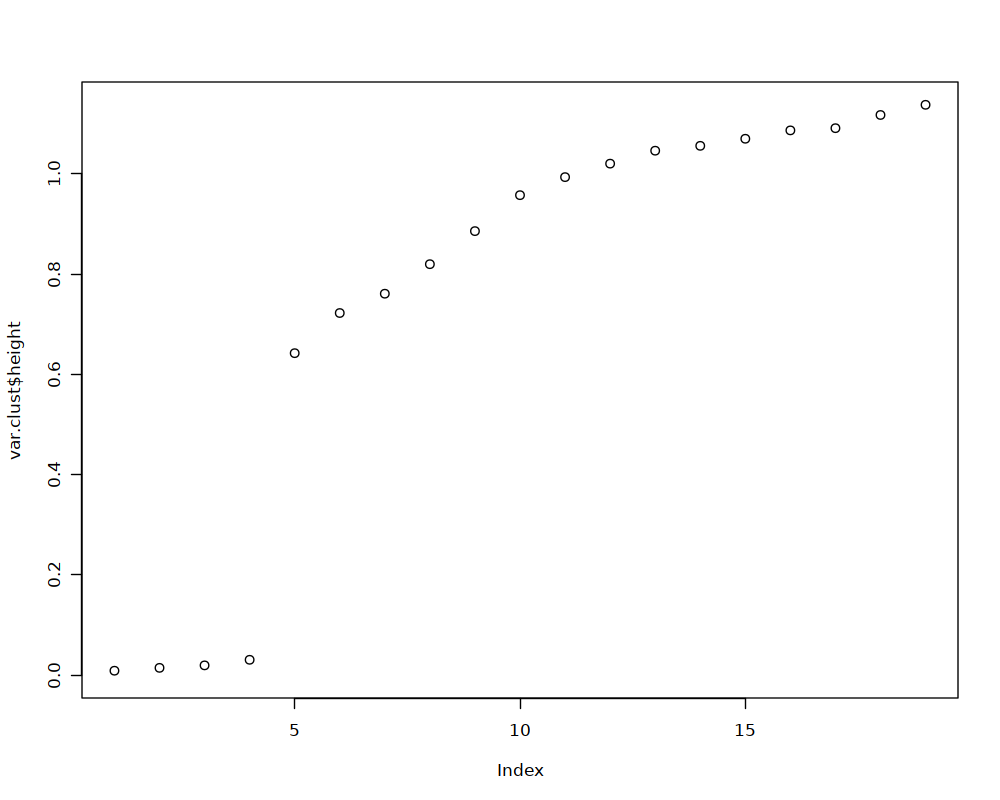

In [230]:
plot(var.clust$height, ylim = c(0, max(var.clust$height)))

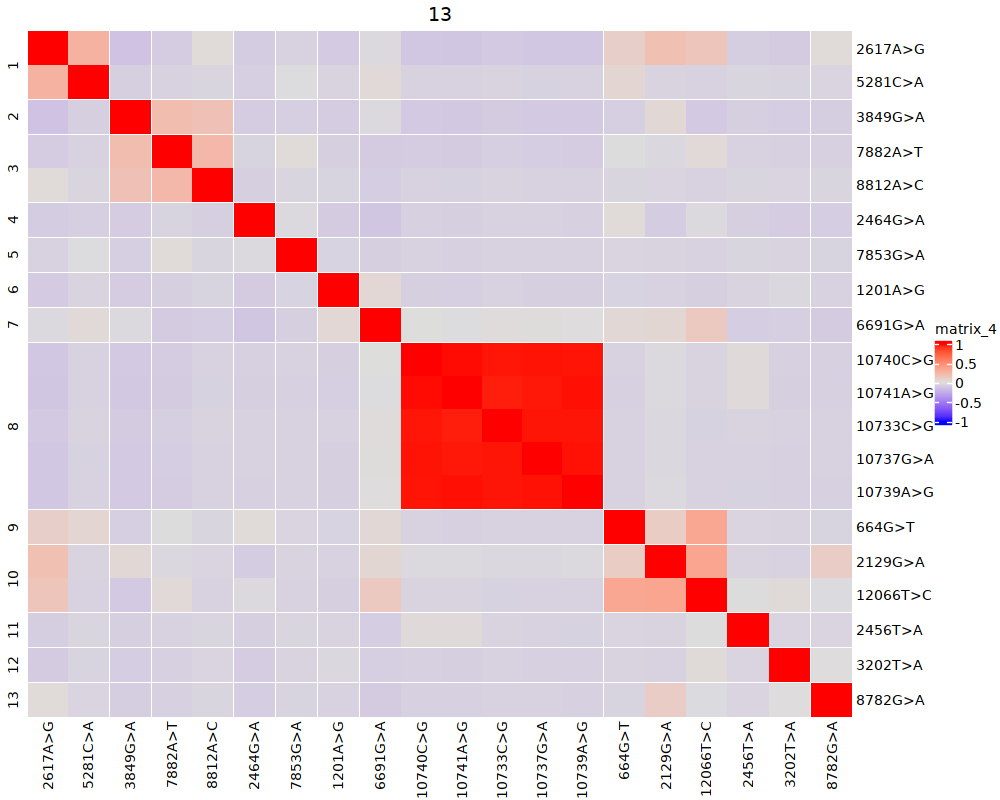

In [231]:

ngroups=length(var.clust$height) - sum(var.clust$height<0.8) + 1
Heatmap(cor.mat,
               col = colorRamp2(c(-1,0,1), c("blue", "#DDDDDD", "red")),
               cluster_columns = var.clust,
               cluster_rows = var.clust,
               row_split = switch(ngroups < length(voi.ch), ngroups),
               column_split = switch(ngroups < length(voi.ch), ngroups),
               show_row_dend = F, # without this the visualizationn does not complete
               show_column_dend = F, # without this the visualizationn does not complete
               row_gap = unit(0.5, "mm"),
               column_gap = unit(0.5, "mm"),
               row_names_gp = gpar(fontsize = 10),
               column_names_gp = gpar(fontsize = 10),
               row_title_gp = gpar(fontsize = 10),
               #width = unit(150, "mm"),
               #height = unit(150, "mm"),
               column_title = ngroups)

In [232]:
Groups.tib <- tibble(var = names(cutree(var.clust, k = ngroups)), Cut = cutree(var.clust, k = ngroups))[var.clust$order,]
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% mutate(Group = match(Cut, unique(Cut)))
Groups.tib <- Groups.tib %>% group_by(Group) %>% summarize(vars = toString(var), nvar = n())
GroupIDs.ls <- lapply(str_split(Groups.tib$vars, ", "), function(x) c(sapply(x, function(y) colnames(af.dm[,af.dm[y,] > 1]))))
Groups.tib$ncells <- unlist(lapply(GroupIDs.ls, function(x) length(unique(unlist(x)))))           
Groups.tib <- Groups.tib %>% arrange(desc(ncells), desc(nvar))

In [233]:
identical(sort(voi.ch),sort(unlist(str_split(Groups.tib$vars, ", "))))

[1] TRUE

In [234]:
#~~~~~~~~~~~~~#
# VAF heatmap #
#~~~~~~~~~~~~~#

# Sort for all variants from the correlation matrix
plot_order.mat <- af_subset.mat[unlist(str_split(Groups.tib$vars, ", ")),]
# Customize column order.
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        plot_order.mat <- plot_order.mat[,order(-plot_order.mat[x,])]
    } else {
        plot_order.mat <- plot_order.mat[,order(-colSums(plot_order.mat[x,]))]
    }
}

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



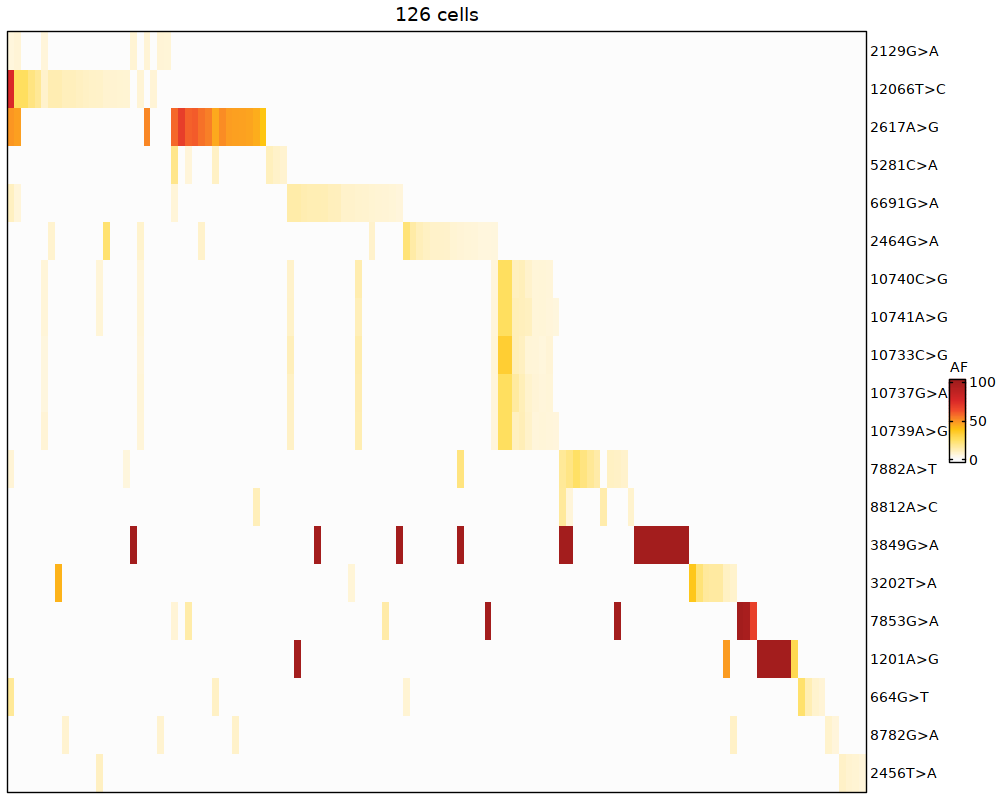

In [235]:
Heatmap(plot_order.mat, column_title = paste0(ncol(plot_order.mat)," cells"), 
               col = colorRamp2(seq(0, round(max(plot_order.mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)

Clone info has been saved to /syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/CIV_clones_SLE232.csv

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



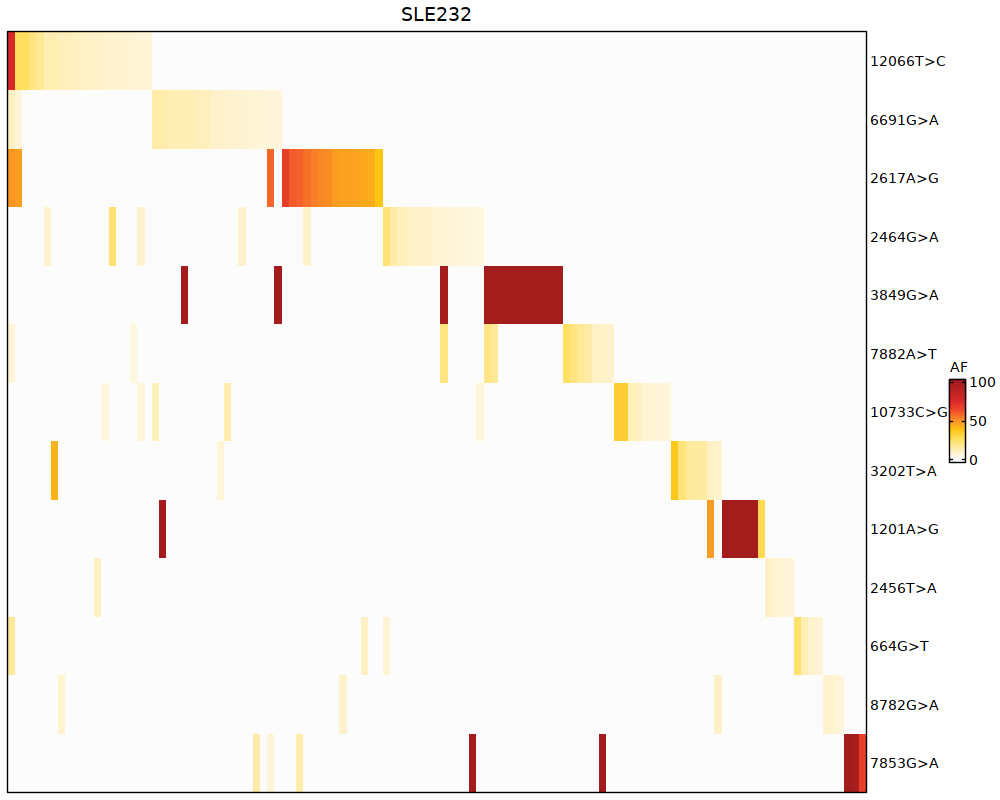

In [236]:
tmp = Groups.tib$vars[Groups.tib$nvar >1]

if (length(tmp) > 0) {Groups.tib$vars[Groups.tib$nvar >1] = sapply(strsplit(tmp, ","), function (x) {
    names(sort(rowMeans(af.dm[unlist(strsplit(gsub(" ", "",x), ",")),]), decreasing = T)[1])
                                                                   }
                                )
                     }
#make a new matrix containing only CIV
CIV = unlist(Groups.tib$vars)
new_plot_mat = plot_order.mat[CIV,]
#sort the new CIV VAF matrix
for (x in rev(strsplit(Groups.tib$vars, ", "))) {
    if (length(x) == 1) {
        new_plot_mat <- new_plot_mat[,order(-new_plot_mat[x,])]
    } else {
        new_plot_mat <- new_plot_mat[,order(-colSums(new_plot_mat[x,]))]
    }
}


right_end = sapply(CIV, function(x) tail(which(new_plot_mat[x,]>0), 1))
right_bor = 0
CIV_idx = c() 
for (i in 1:length(right_end)) {
    if (right_end[i]>right_bor) {
        right_bor = right_end[i]
        CIV_idx = c(CIV_idx, i)
                        }}
right_end = right_end[CIV_idx]
CIV = CIV[CIV_idx]
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1
CIV = CIV[cell_num>0] #remove CIVs that are misclustered
new_plot_mat = new_plot_mat[CIV,]
                       
new1 = new_plot_mat[CIV[rev(order(cell_num))],]
my_command = paste0("order(", paste0("-new1[", 1:nrow(new1), ",]", collapse = ","), ")")
new2 = new1[, eval(parse(text = my_command))]
new2 = new2[ , colSums(new2)>0]
CIV = rownames(new2)
right_end = sapply(CIV, function(x) tail(which(new2[x,]>0), 1))
left_end = c(1, sapply(right_end[1:length(right_end)-1], function(x) x+1))
cell_num = right_end - left_end + 1                     
clone_info_df = data.frame(Cell = colnames(new2), Clone = rep(CIV, cell_num))
write.csv(clone_info_df, file = paste0("/syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/CIV_clones_SLE232.csv"), quote = F, row.names = F)
message("Clone info has been saved to /syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/CIV_clones_SLE232.csv")

new_plot_mat = new2
                                   
htmap_p = Heatmap(new_plot_mat, column_title = simul_id, 
               col = colorRamp2(seq(0, 100, length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #top_annotation = ha,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
htmap_p
                       

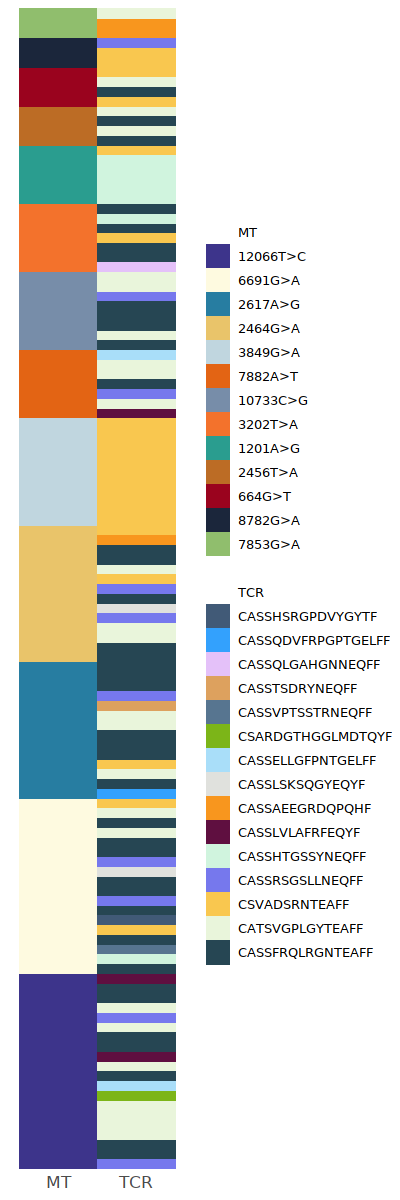

In [237]:
options(repr.plot.width = 4, repr.plot.height = 12, repr.plot.res = 100)
col_pal = sample(col_pal)
#col_pal = readRDS("/syn1/wangxin/work/SS2/Li/plots/col_pal_fig2_SS2_TCR_20240301.rds")

TCR_df = data.frame("TCR" = tcr_meta[colnames(new_plot_mat), "CDR3b"], row.names = colnames(new_plot_mat))
TCR_seq = unique(TCR_df$TCR)


bar_plot_df = cbind(clone_info_df, TCR_df)
TCR_freq_df = as.data.frame(table(bar_plot_df$TCR))
TCR_order = as.character(TCR_freq_df[order(TCR_freq_df$Freq),"Var1"])
mt_order = unique(bar_plot_df$Clone)


df_log = pivot_longer(bar_plot_df, cols = c("Clone", "TCR"), names_to = "Variable", values_to = "Value")
df_log$Cell = factor(df_log$Cell, levels = colnames(new_plot_mat))
legend_order = c("MT", mt_order, " ","TCR", TCR_order)
df_log$Value = factor(df_log$Value, levels = legend_order)


# Create a color palette
pal1 <- c("white", col_pal[1:length(mt_order)], "white", "white", col_pal[(length(mt_order)+1):(length(mt_order)+length(TCR_order))])
names(pal1) = legend_order

if (length(mt_order)+length(TCR_order) > length(col_pal)) {
    extra_col_num = length(mt_order) + length(TCR_order) - length(col_pal)
    pal1[legend_order[(length(col_pal)+1+3): (length(col_pal) + extra_col_num+3)]] = sample(col_pal[1:length(mt_order)], extra_col_num)
    }


# Plot the stacked bar plot with "CLL" on the y-axis
p = ggplot(df_log, aes(x = Variable, y = Cell, fill = Value)) +
  geom_tile() +
  scale_fill_manual(name = NULL,values = pal1, drop=FALSE) +   guides(fill=guide_legend(ncol=1)) +
   theme(legend.position="right", 
         legend.key = element_rect(fill=NA),
         legend.title=element_blank()) + theme_classic() +
          theme(axis.text.y = element_blank(),
            axis.ticks = element_blank(),
            axis.title.y = element_blank(), axis.title.x = element_blank(), axis.text.x = element_text(size = 12, face = "italic"), axis.line = element_blank()) + 
            scale_x_discrete(breaks=c("Clone","TCR"), labels=c("MT", "TCR"))
p
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_MT_to_TCR_correlation.pdf", p, height = 4, width = 4)

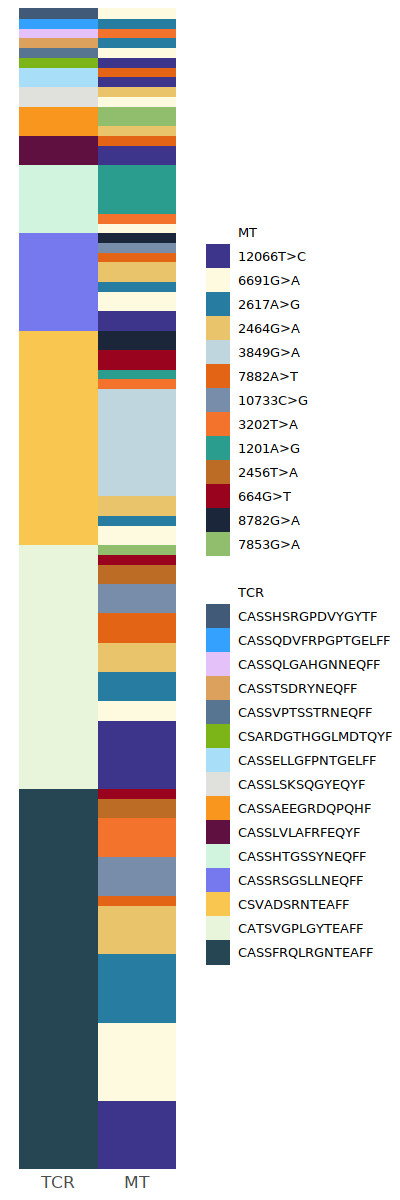

In [238]:
cell_order_by_TCR = bar_plot_df$Cell[order(match(bar_plot_df$TCR, rev(TCR_order)))]
df_log2 = pivot_longer(bar_plot_df, cols = c("Clone", "TCR"), names_to = "Variable", values_to = "Value")
df_log2 = df_log2[order(match(df_log2$Cell, cell_order_by_TCR)),]
df_log2$Cell = factor(df_log2$Cell, levels = cell_order_by_TCR)

legend_order = c("MT", mt_order, " ","TCR", TCR_order)
df_log2$Value = factor(df_log2$Value, levels = legend_order)

df_log2$Variable = factor(df_log2$Variable, levels = c("TCR", "Clone"))

p0 = ggplot(df_log2, aes(x = Variable, y = Cell, fill = Value)) +
  geom_tile() +
  scale_fill_manual(name = NULL,values = pal1, drop=FALSE) + guides(fill=guide_legend(ncol=1)) +
   theme(legend.position="right", 
         legend.key = element_rect(fill=NA),
         legend.title=element_blank()) + theme_classic() +
          theme(axis.text.y = element_blank(),
            axis.ticks = element_blank(),
            axis.title.y = element_blank(), axis.title.x = element_blank(), axis.text.x = element_text(size = 12, face = "bold"), axis.line = element_blank()) + 
            scale_x_discrete(breaks=c("TCR","Clone"), labels=c("TCR", "MT"))
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_TCR_to_MT_correlation.pdf", p0, height = 4, width = 4)
p0

In [240]:
sample_name = "SLE232"
out_dir = paste0("/syn1/wangxin/work/SS2/Li/samples/", sample_name, "/")
new_plot_mat1 = new_plot_mat/100 
all_mean_ls = c()
all_var_ls = c()
sub_mean_ls = c()
sub_var_ls = c()
all_mv1_ls = c()
sub_mv1_ls = c()


for (x in 1:length(CIV)) {
        #all positive cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],][new_plot_mat1[CIV[x],] >= 0.05]
        all_mean_ls = append(all_mean_ls, mean(tmp_vaf_ls))
        all_var_ls = append(all_var_ls, var(tmp_vaf_ls))
        all_mv1_ls = append(all_mv1_ls, mean(tmp_vaf_ls)/(var(tmp_vaf_ls)+1))
        
        #sub cells
        tmp_vaf_ls = new_plot_mat1[CIV[x],clone_info_df$Cell[clone_info_df$Clone == CIV[x]]]
        tmp_vaf_ls = tmp_vaf_ls[tmp_vaf_ls >= 0.05]
        sub_mean_ls = append(sub_mean_ls, mean(tmp_vaf_ls))
        sub_var_ls = append(sub_var_ls, var(tmp_vaf_ls))
        sub_mv1_ls = append(sub_mv1_ls, mean(tmp_vaf_ls)/(var(tmp_vaf_ls)+1))
        }

meanvar_df_all = data.frame("Clone" = CIV, "Mean" = all_mean_ls, "Variance" = all_var_ls, "MV1" = all_mv1_ls, "Sim" = rep(sample_name, length(CIV)), "Method" = rep("All", length(CIV)))
meanvar_df_sub= data.frame("Clone" = CIV, "Mean" = sub_mean_ls, "Variance" = sub_var_ls, "MV1" = sub_mv1_ls, "Sim" = rep(sample_name, length(CIV)),  "Method" = rep("Sub", length(CIV)))

meanvar_df = rbind(meanvar_df_all, meanvar_df_sub)
meanvar_file_name = paste0(out_dir,"/CIV/meanvar_CIV_", sample_name, ".csv")
write.csv(meanvar_df, file = meanvar_file_name, quote = F, row.names = F)
message("Mean and variance info have been saved to: ", meanvar_file_name)

Mean and variance info have been saved to: /syn1/wangxin/work/SS2/Li/samples/SLE232//CIV/meanvar_CIV_SLE232.csv



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



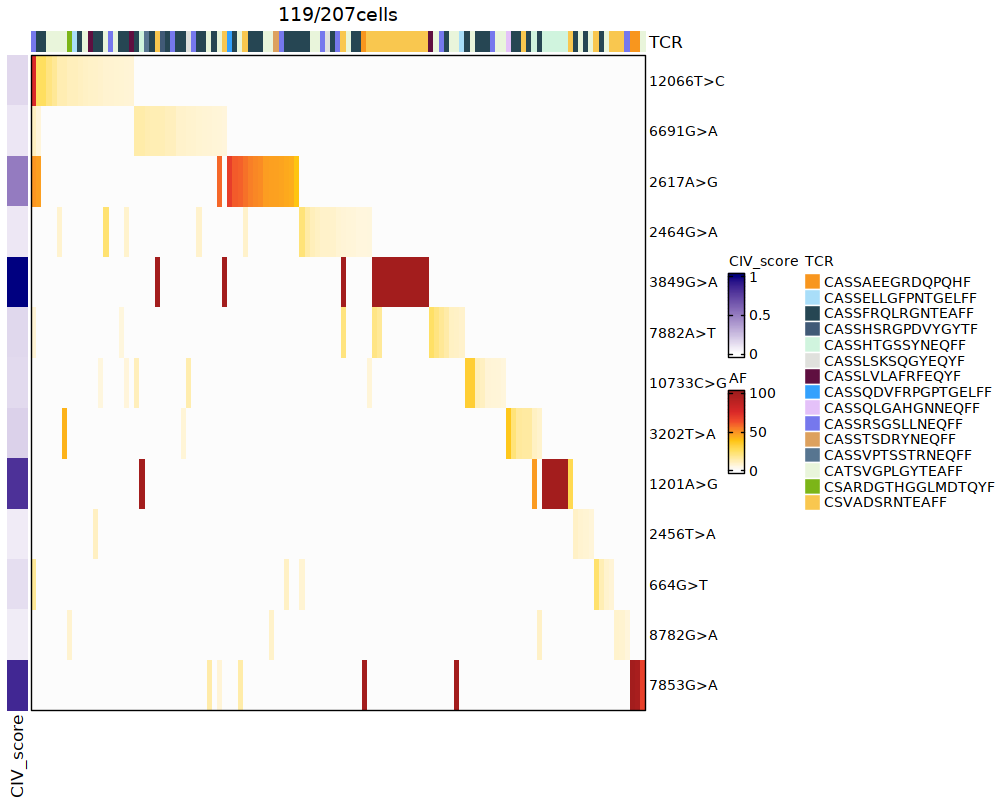

In [248]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)
ann_col = list("TCR"=pal1[TCR_seq])
names(ann_col$TCR) = TCR_seq
ha = HeatmapAnnotation(df = TCR_df, col = ann_col)

#define annotation for CIVs
ra_pal = colorRamp2(c(0, 1), c( "white", "navyblue"))
row_annot <- rowAnnotation(
  df = data.frame(CIV_score = sub_mv1_ls),
  col = list(CIV_score = ra_pal), annotation_legend_param = list(border = "#000000"))
#new_plot_mat = new_plot_mat[c(1:9,11,13:nrow(new_plot_mat)),]
p1 = Heatmap(new_plot_mat, column_title = paste0(ncol(new_plot_mat),"/",length(sub_cells),"cells"), 
               col = colorRamp2(seq(0, round(max(new_plot_mat)), length.out = 9),
                                c("#FCFCFC","#FFEDB0","#FFDF5F","#FEC510","#FA8E24","#F14C2B","#DA2828","#BE2222","#A31D1D")),
               show_row_names = T,
               show_column_names = F,
               cluster_columns = F,
               cluster_rows = F,
               row_names_gp = gpar(fontsize = 10),
               name = "AF",
               heatmap_legend_param = list(border = "#000000", grid_height = unit(5, "mm")),
               #left_annotation = row_annot,
               top_annotation = ha,
             left_annotation = row_annot,
               border = T,
               #width = unit(100, "mm"),
               #height = unit(100, "mm"),
               use_raster = T,
               raster_quality = 5)
p1

In [246]:
pdf(paste0("/syn1/wangxin/work/SS2/Li/plots/SLE232_CIV_heatmap.pdf"), height = 2.645, width = 6)
p1
dev.off()

png 
  2

In [249]:
saveRDS(file = "/syn1/wangxin/work/SS2/Li/plots/col_pal_fig2_SS2_TCR_SLE232_20240419.rds", col_pal)

In [222]:
umap_meta = read.csv("/syn1/wangxin/work/SS2/Li/new_tcr_meta.csv", head=T, row.names = 1, check.names = F)

meta_sub = umap_meta[umap_meta$`patient ID` == simul_id,]

new_meta = meta_sub[,c("UMAP_1", "UMAP_2", "CDR3b")]
clone_info_df = read.csv("/syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/CIV_clones_SLE232.csv")

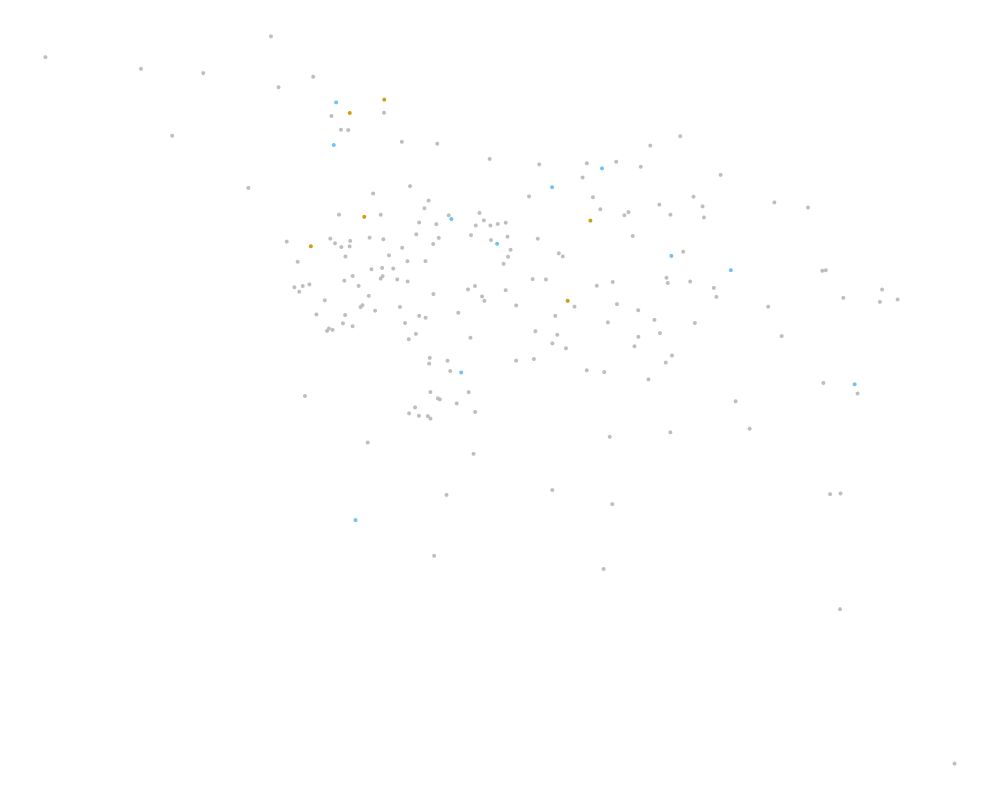

In [223]:
new_meta$MT = "Other"
pos_3849 = clone_info_df$Cell[clone_info_df$Clone == "3849G>A"]
pos_1201 = clone_info_df$Cell[clone_info_df$Clone == "1201A>G"]
new_meta[pos_3849, "MT"] = "3849G>A"
new_meta[pos_1201, "MT"] = "1201A>G"
new_meta = new_meta[rev(order(new_meta$MT)),]
new_meta$MT = factor(new_meta$MT, levels = c("3849G>A", "1201A>G", "Other"))
p2 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = MT)) + geom_point(size=1, stroke = 0 ) + theme_void() + scale_color_manual(values = c("#6DC2F7", "#CF9C13", "gray")) + theme(legend.position = "none")
p2
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_MT_UMAP.pdf", p2, height = 2, width = 2)

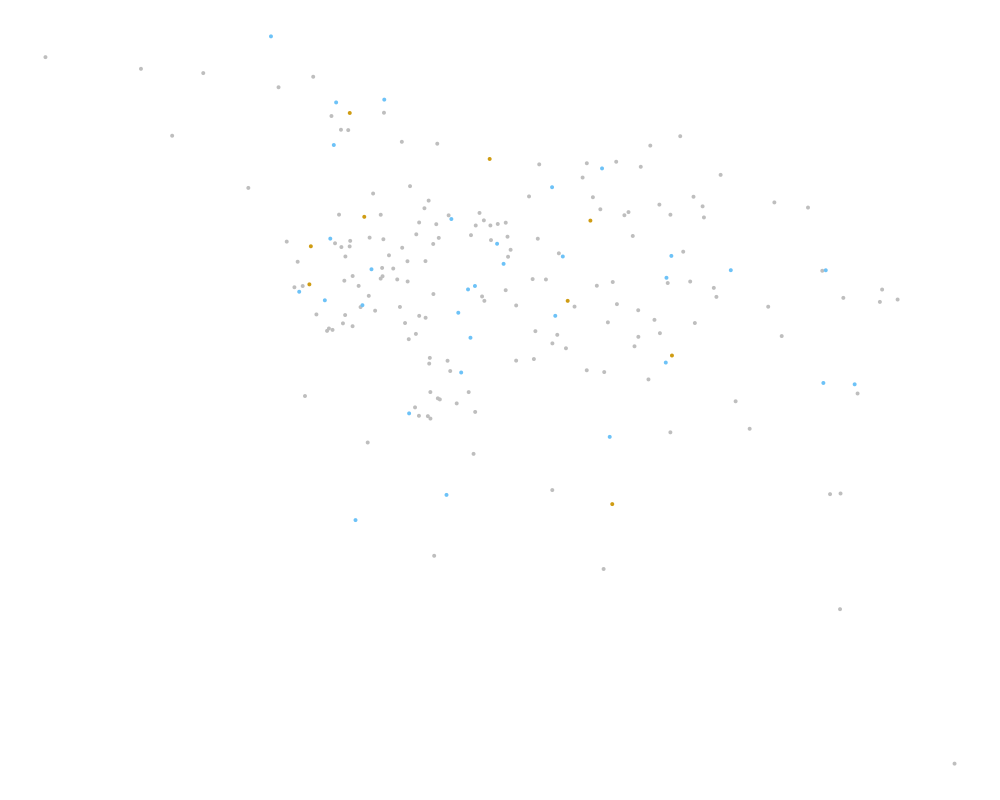

In [224]:
new_meta$TCR = "Other"
new_meta[new_meta$CDR3b == "CSVADSRNTEAFF", "TCR"] = "CSVADSRNTEAFF"
new_meta[new_meta$CDR3b == "CASSHTGSSYNEQFF", "TCR"] = "CASSHTGSSYNEQFF"
new_meta = new_meta[rev(order(new_meta$TCR)),]
new_meta$TCR = factor(new_meta$TCR, levels = c("CSVADSRNTEAFF", "CASSHTGSSYNEQFF", "Other"))
p4 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = TCR)) + geom_point(size=1, stroke = 0 ) + theme_void() + scale_color_manual(values = c("#6DC2F7", "#CF9C13", "gray")) + theme(legend.position = "none")
p4
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_TCR_UMAP.pdf", p4, height = 2, width = 2)

In [454]:
new_meta$C1= "No"
new_meta$C2 = "No"
pos_3849 = clone_info_df$Cell[clone_info_df$Clone == "3849G>A"]
pos_1201 = clone_info_df$Cell[clone_info_df$Clone == "1201A>G"]
new_meta[pos_3849,"C1"] = "Yes"
new_meta[pos_1201,"C2"] = "Yes"
#new_meta[MT_neg,"MT"] = "3202T>A"

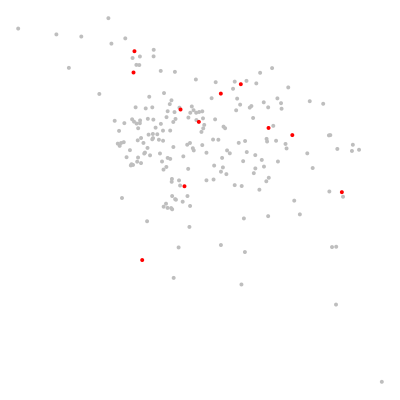

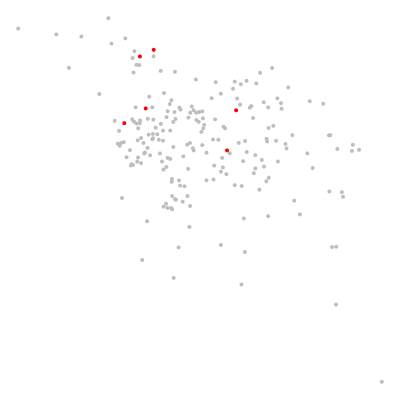

In [469]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 100)
new_meta$C1 = factor(new_meta$C1, levels = c("Yes", "No"))
new_meta = new_meta[rev(order(new_meta$C1)),]
p2 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = C1)) + geom_point(size=1, stroke = 0 ) + theme_void() + scale_color_manual(values = c("red", "gray")) + theme(legend.position = "none")
p2

new_meta$C2 = factor(new_meta$C2, levels = c("Yes", "No"))
new_meta = new_meta[rev(order(new_meta$C2)),]
p3 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = C2)) + geom_point(size=1, stroke = 0 ) + theme_void() + scale_color_manual(values = c("red", "gray")) + theme(legend.position = "none")
p3


In [476]:
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_MT_UMAP_3849GA.pdf", p2, height = 2, width = 2)
ggsave("/syn1/wangxin/work/SS2/Li/plots/SLE232_MT_UMAP_1201AG.pdf", p3, height = 2, width = 2)

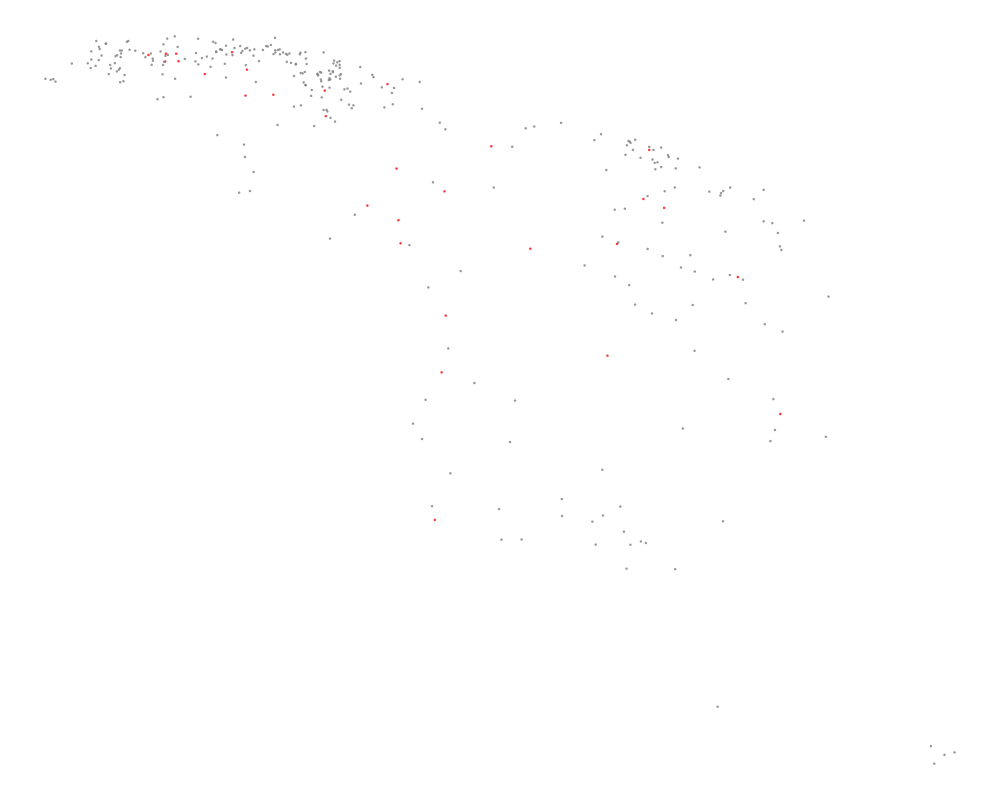

In [103]:
new_meta$T1 = "No"
new_meta[new_meta$CDR3b == "CASSQVARGYSGANVLTF", "TCR"] =  "CASSQVARGYSGANVLTF"
p3 = ggplot(new_meta, aes(x= UMAP_1, y=UMAP_2, color = TCR)) + geom_point(size=0.5, alpha= 0.8,  stroke = 0) + theme_void() + scale_color_manual(values = c("red", "gray")) + theme(legend.position = "none")
p3
ggsave("/syn1/wangxin/work/SS2/Li/plots/MS0816_TCR_UMAP.pdf", p3, height = 2, width = 2)